In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import sys

In [24]:
def build_data(wine_data, factor1, factor2, good_thresh, bad_thresh):
    # pandas read csv as DataFrame
    df = pd.read_csv(wine_data, delimiter=";")
    # Only catch data over or below threshold
    for i in range(len(df)):
        if (df.loc[i, 'quality'] < good_thresh and df.loc[i, 'quality'] > bad_thresh):
            df = df.drop([i])
    # build dataFrame
    df = df[[factor1, factor2]]
    df.insert(0, 'bias', 1)
    return df
    
def build_target(wine_data, good_thresh, bad_thresh):
    # pandas read csv as DataFrame
    df = pd.read_csv(wine_data, delimiter=";")
    # Only catch data over or below threshold, and transfer to 1 & 0
    for i in range(len(df)):
        if (df.loc[i, 'quality'] >= good_thresh):
            df.loc[i, 'quality'] = 1
        elif (df.loc[i, 'quality'] <= bad_thresh):
            df.loc[i, 'quality'] = 0
        else:
            df = df.drop([i])
    # build dataFrame
    target = pd.DataFrame(df['quality'].values, columns=['target'])    
    return (target)

In [25]:
class ANN:    
    def ft_dot(self, m1, m2):
        m1_row, m1_col = m1.shape
        m2_row, m2_col = m2.shape
        m = [[0 for j in range(m2_col)] for i in range(m1_row)]
        for i in range(m1_row):
            for j in range(m2_col):
                m[i][j] = self.getNetValue(m1.iloc[i], m2.iloc[:,j])
        return pd.DataFrame(m)                 
    
    def getNetValue(self, s1, s2):
        net = 0;
        for i in range(len(s1)):
            net += s1.iloc[i] * s2.iloc[i]
        return net
    
    def ft_sub(self, m1, m2):
        m1_row, m1_col = m1.shape
        m = [[0 for j in range(m1_col)] for i in range(m1_row)]
        for i in range(m1_row):
            for j in range(m1_col):
                m[i][j] = m1.iloc[i, j] - m2.iloc[i, j]
        return pd.DataFrame(m)
    
    def ft_transpose(self, m1):
        m1_row, m1_col = m1.shape
        m = pd.DataFrame()
        for i in range(m1_col):
            m = m.append(m1.iloc[:,i])
        return m
    
    def ft_add(self, m1, m2):
        m1_row, m1_col = m1.shape
        m = [[0 for j in range(m1_col)] for i in range(m1_row)]
        for i in range(m1_row):
            for j in range(m1_col):
                m[i][j] = m1.iloc[i, j] + m2.iloc[i, j]
        return pd.DataFrame(m)
    
    def errorCount(self, predict, target):
        count = 0
        for i in range(len(predict)):
            if predict.iloc[i].values != target.iloc[i].values:
                count += 1
        return count

In [26]:
class Perceptron(ANN):
    def __init__(self, lr, epoch):
        ANN.__init__(self)
        self.lr = lr
        if (epoch <= 0):
            epoch = sys.maxsize
        self.epoch = epoch
        
    def train(self, data, target):
        curEpoch = 0
        performance = []
        
        # get data shape
        dataRow, dataCol = data.shape
        
        # Randomize weight
        self.weight = pd.DataFrame([random.uniform(0, 1)] for _ in range(dataCol))
        
        # start training
        for _ in range(self.epoch):
            # updateWeight
            netInput = self.ft_dot(data, self.weight)
            predictOutput = self.predict(netInput)
            error = self.ft_sub(target, predictOutput)
            deltaW = self.lr * self.ft_dot(self.ft_transpose(data), error)
            self.weight = self.ft_add(self.weight, deltaW)
            # record performance
            curEpoch += 1
            errorNumber = self.errorCount(predictOutput, target)
            performance.append((curEpoch, errorNumber, self.weight.values))
            print(f"Training preceptron, curEpoch: {curEpoch}, errorNumber: {errorNumber}")
            if (self.epoch == sys.maxsize and errorNumber <= 0):
                break
        return performance

        
    def predict(self, source):
        for i in range(len(source)):
            if (source.iloc[i].values >= 0):
                source.iloc[i] = 1
            else:
                source.iloc[i] = 0
        return source 
    
    def activation(self, data, weight):
        return self.ft_dot(data, weight)

In [27]:
def draw_number_of_errors(ax, performance, epoch):
    # epoch error check
    if (epoch == -1):
        epoch = len(performance)
    
    # set scatter plot x and y
    er = []
    ep = []
    for i in range(epoch):
        ep.append(performance[i][0])
        er.append(performance[i][1])
    
    # draw scatter plot
    ax[0].plot(ep, er, label='Errors as a function of epoch')
    ax[0].set(xlabel='Epoch', ylabel='Error')

def draw_decision_boundary(ax, performance, epoch):
    # set boundary
    x_min = data.iloc[:,1].min()
    x_max = data.iloc[:,1].max()
    y_min = data.iloc[:,2].min()
    y_max = data.iloc[:,2].max()
    x_rg = x_max - x_min
    y_rg = y_max - y_min
    ax[1].set_xlim([x_min - 0.05 * x_rg, x_max + 0.05 * x_rg])
    ax[1].set_ylim([y_min - 0.05 * y_rg, y_max + 0.05 * y_rg])
    
    # get decision boundary line equation
    wx = performance[epoch][2][1][0]
    wy = performance[epoch][2][2][0]
    b = performance[epoch][2][0][0]
    slope = -wx/wy
    intercept = -b/wy
    x_coords = range(int(x_min) - 1, int(x_max) + 2)
    y_coords = slope * x_coords + intercept
    
    # draw Drecision boundary
    ax[1].plot(x_coords, y_coords, 'b--', label='Decision boundary')
    ax[1].fill_between(x_coords, y_coords, y_min - 0.05 * y_rg, color='pink')
    ax[1].fill_between(x_coords, y_coords, y_max + 0.05 * y_rg, color='palegreen')
    
def draw_scatter_plot(ax, data, target):
    color = []
    # color in scatter plot
    for i in range(len(target)):
        if (target.iloc[i, 0] == 1):
            color.append('green')
        else:
            color.append('red')
    # draw
    ax[1].scatter(data.iloc[:,1].values,data.iloc[:,2].values, c=color, s=10)
    ax[1].set(xlabel=data.columns[1], ylabel=data.columns[2])
    
    
def plot_performace(performance, data, target, good_thresh, bad_thresh, epoch=-1, save_plot=False):
    # set subplot
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
     
    # some epoch error check
    if (epoch > len(performance)):
        epoch = len(performance)
    
    # draw
    draw_number_of_errors(ax, performance, epoch)
    draw_decision_boundary(ax, performance, epoch)
    draw_scatter_plot(ax, data, target)

    fig.show()
    
    if save_plot:
        fig.savefig("Performance Plot: " + data.columns[1] + " & " + data.columns[2])

In [28]:
data = build_data("winequality-red.csv", 'pH', 'alcohol', 8, 3)
target = build_target("winequality-red.csv", 8, 3)

In [29]:
precep = Perceptron(0.5, 0)
performance = precep.train(data, target)

Training preceptron, curEpoch: 1, errorNumber: 10
Training preceptron, curEpoch: 2, errorNumber: 18
Training preceptron, curEpoch: 3, errorNumber: 10
Training preceptron, curEpoch: 4, errorNumber: 10
Training preceptron, curEpoch: 5, errorNumber: 18
Training preceptron, curEpoch: 6, errorNumber: 10
Training preceptron, curEpoch: 7, errorNumber: 10
Training preceptron, curEpoch: 8, errorNumber: 18
Training preceptron, curEpoch: 9, errorNumber: 10
Training preceptron, curEpoch: 10, errorNumber: 10
Training preceptron, curEpoch: 11, errorNumber: 18
Training preceptron, curEpoch: 12, errorNumber: 10
Training preceptron, curEpoch: 13, errorNumber: 10
Training preceptron, curEpoch: 14, errorNumber: 18
Training preceptron, curEpoch: 15, errorNumber: 10
Training preceptron, curEpoch: 16, errorNumber: 10
Training preceptron, curEpoch: 17, errorNumber: 18
Training preceptron, curEpoch: 18, errorNumber: 10
Training preceptron, curEpoch: 19, errorNumber: 10
Training preceptron, curEpoch: 20, error

Training preceptron, curEpoch: 161, errorNumber: 10
Training preceptron, curEpoch: 162, errorNumber: 10
Training preceptron, curEpoch: 163, errorNumber: 12
Training preceptron, curEpoch: 164, errorNumber: 10
Training preceptron, curEpoch: 165, errorNumber: 2
Training preceptron, curEpoch: 166, errorNumber: 2
Training preceptron, curEpoch: 167, errorNumber: 3
Training preceptron, curEpoch: 168, errorNumber: 1
Training preceptron, curEpoch: 169, errorNumber: 2
Training preceptron, curEpoch: 170, errorNumber: 2
Training preceptron, curEpoch: 171, errorNumber: 1
Training preceptron, curEpoch: 172, errorNumber: 2
Training preceptron, curEpoch: 173, errorNumber: 2
Training preceptron, curEpoch: 174, errorNumber: 2
Training preceptron, curEpoch: 175, errorNumber: 2
Training preceptron, curEpoch: 176, errorNumber: 2
Training preceptron, curEpoch: 177, errorNumber: 2
Training preceptron, curEpoch: 178, errorNumber: 3
Training preceptron, curEpoch: 179, errorNumber: 1
Training preceptron, curEpo

Training preceptron, curEpoch: 322, errorNumber: 1
Training preceptron, curEpoch: 323, errorNumber: 2
Training preceptron, curEpoch: 324, errorNumber: 2
Training preceptron, curEpoch: 325, errorNumber: 1
Training preceptron, curEpoch: 326, errorNumber: 2
Training preceptron, curEpoch: 327, errorNumber: 2
Training preceptron, curEpoch: 328, errorNumber: 2
Training preceptron, curEpoch: 329, errorNumber: 2
Training preceptron, curEpoch: 330, errorNumber: 3
Training preceptron, curEpoch: 331, errorNumber: 1
Training preceptron, curEpoch: 332, errorNumber: 3
Training preceptron, curEpoch: 333, errorNumber: 1
Training preceptron, curEpoch: 334, errorNumber: 2
Training preceptron, curEpoch: 335, errorNumber: 2
Training preceptron, curEpoch: 336, errorNumber: 1
Training preceptron, curEpoch: 337, errorNumber: 2
Training preceptron, curEpoch: 338, errorNumber: 2
Training preceptron, curEpoch: 339, errorNumber: 2
Training preceptron, curEpoch: 340, errorNumber: 2
Training preceptron, curEpoch: 

Training preceptron, curEpoch: 483, errorNumber: 3
Training preceptron, curEpoch: 484, errorNumber: 1
Training preceptron, curEpoch: 485, errorNumber: 2
Training preceptron, curEpoch: 486, errorNumber: 2
Training preceptron, curEpoch: 487, errorNumber: 1
Training preceptron, curEpoch: 488, errorNumber: 2
Training preceptron, curEpoch: 489, errorNumber: 2
Training preceptron, curEpoch: 490, errorNumber: 2
Training preceptron, curEpoch: 491, errorNumber: 2
Training preceptron, curEpoch: 492, errorNumber: 2
Training preceptron, curEpoch: 493, errorNumber: 2
Training preceptron, curEpoch: 494, errorNumber: 2
Training preceptron, curEpoch: 495, errorNumber: 2
Training preceptron, curEpoch: 496, errorNumber: 2
Training preceptron, curEpoch: 497, errorNumber: 1
Training preceptron, curEpoch: 498, errorNumber: 2
Training preceptron, curEpoch: 499, errorNumber: 2
Training preceptron, curEpoch: 500, errorNumber: 2
Training preceptron, curEpoch: 501, errorNumber: 2
Training preceptron, curEpoch: 

Training preceptron, curEpoch: 644, errorNumber: 3
Training preceptron, curEpoch: 645, errorNumber: 1
Training preceptron, curEpoch: 646, errorNumber: 2
Training preceptron, curEpoch: 647, errorNumber: 2
Training preceptron, curEpoch: 648, errorNumber: 1
Training preceptron, curEpoch: 649, errorNumber: 2
Training preceptron, curEpoch: 650, errorNumber: 2
Training preceptron, curEpoch: 651, errorNumber: 2
Training preceptron, curEpoch: 652, errorNumber: 2
Training preceptron, curEpoch: 653, errorNumber: 2
Training preceptron, curEpoch: 654, errorNumber: 2
Training preceptron, curEpoch: 655, errorNumber: 3
Training preceptron, curEpoch: 656, errorNumber: 1
Training preceptron, curEpoch: 657, errorNumber: 2
Training preceptron, curEpoch: 658, errorNumber: 2
Training preceptron, curEpoch: 659, errorNumber: 1
Training preceptron, curEpoch: 660, errorNumber: 2
Training preceptron, curEpoch: 661, errorNumber: 2
Training preceptron, curEpoch: 662, errorNumber: 2
Training preceptron, curEpoch: 

Training preceptron, curEpoch: 805, errorNumber: 2
Training preceptron, curEpoch: 806, errorNumber: 1
Training preceptron, curEpoch: 807, errorNumber: 2
Training preceptron, curEpoch: 808, errorNumber: 1
Training preceptron, curEpoch: 809, errorNumber: 1
Training preceptron, curEpoch: 810, errorNumber: 2
Training preceptron, curEpoch: 811, errorNumber: 2
Training preceptron, curEpoch: 812, errorNumber: 2
Training preceptron, curEpoch: 813, errorNumber: 2
Training preceptron, curEpoch: 814, errorNumber: 3
Training preceptron, curEpoch: 815, errorNumber: 1
Training preceptron, curEpoch: 816, errorNumber: 2
Training preceptron, curEpoch: 817, errorNumber: 2
Training preceptron, curEpoch: 818, errorNumber: 1
Training preceptron, curEpoch: 819, errorNumber: 2
Training preceptron, curEpoch: 820, errorNumber: 1
Training preceptron, curEpoch: 821, errorNumber: 1
Training preceptron, curEpoch: 822, errorNumber: 2
Training preceptron, curEpoch: 823, errorNumber: 2
Training preceptron, curEpoch: 

Training preceptron, curEpoch: 967, errorNumber: 2
Training preceptron, curEpoch: 968, errorNumber: 2
Training preceptron, curEpoch: 969, errorNumber: 2
Training preceptron, curEpoch: 970, errorNumber: 2
Training preceptron, curEpoch: 971, errorNumber: 1
Training preceptron, curEpoch: 972, errorNumber: 2
Training preceptron, curEpoch: 973, errorNumber: 1
Training preceptron, curEpoch: 974, errorNumber: 1
Training preceptron, curEpoch: 975, errorNumber: 2
Training preceptron, curEpoch: 976, errorNumber: 2
Training preceptron, curEpoch: 977, errorNumber: 2
Training preceptron, curEpoch: 978, errorNumber: 2
Training preceptron, curEpoch: 979, errorNumber: 3
Training preceptron, curEpoch: 980, errorNumber: 1
Training preceptron, curEpoch: 981, errorNumber: 2
Training preceptron, curEpoch: 982, errorNumber: 2
Training preceptron, curEpoch: 983, errorNumber: 1
Training preceptron, curEpoch: 984, errorNumber: 2
Training preceptron, curEpoch: 985, errorNumber: 1
Training preceptron, curEpoch: 

Training preceptron, curEpoch: 1127, errorNumber: 1
Training preceptron, curEpoch: 1128, errorNumber: 1
Training preceptron, curEpoch: 1129, errorNumber: 2
Training preceptron, curEpoch: 1130, errorNumber: 2
Training preceptron, curEpoch: 1131, errorNumber: 2
Training preceptron, curEpoch: 1132, errorNumber: 2
Training preceptron, curEpoch: 1133, errorNumber: 3
Training preceptron, curEpoch: 1134, errorNumber: 1
Training preceptron, curEpoch: 1135, errorNumber: 2
Training preceptron, curEpoch: 1136, errorNumber: 2
Training preceptron, curEpoch: 1137, errorNumber: 1
Training preceptron, curEpoch: 1138, errorNumber: 2
Training preceptron, curEpoch: 1139, errorNumber: 1
Training preceptron, curEpoch: 1140, errorNumber: 1
Training preceptron, curEpoch: 1141, errorNumber: 2
Training preceptron, curEpoch: 1142, errorNumber: 2
Training preceptron, curEpoch: 1143, errorNumber: 2
Training preceptron, curEpoch: 1144, errorNumber: 2
Training preceptron, curEpoch: 1145, errorNumber: 3
Training pre

Training preceptron, curEpoch: 1286, errorNumber: 2
Training preceptron, curEpoch: 1287, errorNumber: 2
Training preceptron, curEpoch: 1288, errorNumber: 2
Training preceptron, curEpoch: 1289, errorNumber: 2
Training preceptron, curEpoch: 1290, errorNumber: 1
Training preceptron, curEpoch: 1291, errorNumber: 2
Training preceptron, curEpoch: 1292, errorNumber: 1
Training preceptron, curEpoch: 1293, errorNumber: 1
Training preceptron, curEpoch: 1294, errorNumber: 2
Training preceptron, curEpoch: 1295, errorNumber: 2
Training preceptron, curEpoch: 1296, errorNumber: 2
Training preceptron, curEpoch: 1297, errorNumber: 2
Training preceptron, curEpoch: 1298, errorNumber: 3
Training preceptron, curEpoch: 1299, errorNumber: 1
Training preceptron, curEpoch: 1300, errorNumber: 2
Training preceptron, curEpoch: 1301, errorNumber: 2
Training preceptron, curEpoch: 1302, errorNumber: 1
Training preceptron, curEpoch: 1303, errorNumber: 2
Training preceptron, curEpoch: 1304, errorNumber: 1
Training pre

Training preceptron, curEpoch: 1444, errorNumber: 1
Training preceptron, curEpoch: 1445, errorNumber: 2
Training preceptron, curEpoch: 1446, errorNumber: 2
Training preceptron, curEpoch: 1447, errorNumber: 1
Training preceptron, curEpoch: 1448, errorNumber: 2
Training preceptron, curEpoch: 1449, errorNumber: 1
Training preceptron, curEpoch: 1450, errorNumber: 1
Training preceptron, curEpoch: 1451, errorNumber: 2
Training preceptron, curEpoch: 1452, errorNumber: 2
Training preceptron, curEpoch: 1453, errorNumber: 2
Training preceptron, curEpoch: 1454, errorNumber: 2
Training preceptron, curEpoch: 1455, errorNumber: 3
Training preceptron, curEpoch: 1456, errorNumber: 1
Training preceptron, curEpoch: 1457, errorNumber: 2
Training preceptron, curEpoch: 1458, errorNumber: 2
Training preceptron, curEpoch: 1459, errorNumber: 1
Training preceptron, curEpoch: 1460, errorNumber: 2
Training preceptron, curEpoch: 1461, errorNumber: 1
Training preceptron, curEpoch: 1462, errorNumber: 1
Training pre

Training preceptron, curEpoch: 1603, errorNumber: 2
Training preceptron, curEpoch: 1604, errorNumber: 1
Training preceptron, curEpoch: 1605, errorNumber: 2
Training preceptron, curEpoch: 1606, errorNumber: 1
Training preceptron, curEpoch: 1607, errorNumber: 1
Training preceptron, curEpoch: 1608, errorNumber: 2
Training preceptron, curEpoch: 1609, errorNumber: 2
Training preceptron, curEpoch: 1610, errorNumber: 2
Training preceptron, curEpoch: 1611, errorNumber: 2
Training preceptron, curEpoch: 1612, errorNumber: 3
Training preceptron, curEpoch: 1613, errorNumber: 1
Training preceptron, curEpoch: 1614, errorNumber: 2
Training preceptron, curEpoch: 1615, errorNumber: 2
Training preceptron, curEpoch: 1616, errorNumber: 1
Training preceptron, curEpoch: 1617, errorNumber: 2
Training preceptron, curEpoch: 1618, errorNumber: 1
Training preceptron, curEpoch: 1619, errorNumber: 1
Training preceptron, curEpoch: 1620, errorNumber: 2
Training preceptron, curEpoch: 1621, errorNumber: 2
Training pre

Training preceptron, curEpoch: 1761, errorNumber: 1
Training preceptron, curEpoch: 1762, errorNumber: 2
Training preceptron, curEpoch: 1763, errorNumber: 1
Training preceptron, curEpoch: 1764, errorNumber: 1
Training preceptron, curEpoch: 1765, errorNumber: 2
Training preceptron, curEpoch: 1766, errorNumber: 2
Training preceptron, curEpoch: 1767, errorNumber: 2
Training preceptron, curEpoch: 1768, errorNumber: 2
Training preceptron, curEpoch: 1769, errorNumber: 3
Training preceptron, curEpoch: 1770, errorNumber: 1
Training preceptron, curEpoch: 1771, errorNumber: 2
Training preceptron, curEpoch: 1772, errorNumber: 2
Training preceptron, curEpoch: 1773, errorNumber: 1
Training preceptron, curEpoch: 1774, errorNumber: 2
Training preceptron, curEpoch: 1775, errorNumber: 1
Training preceptron, curEpoch: 1776, errorNumber: 1
Training preceptron, curEpoch: 1777, errorNumber: 2
Training preceptron, curEpoch: 1778, errorNumber: 2
Training preceptron, curEpoch: 1779, errorNumber: 2
Training pre

Training preceptron, curEpoch: 1919, errorNumber: 2
Training preceptron, curEpoch: 1920, errorNumber: 1
Training preceptron, curEpoch: 1921, errorNumber: 1
Training preceptron, curEpoch: 1922, errorNumber: 2
Training preceptron, curEpoch: 1923, errorNumber: 2
Training preceptron, curEpoch: 1924, errorNumber: 2
Training preceptron, curEpoch: 1925, errorNumber: 2
Training preceptron, curEpoch: 1926, errorNumber: 3
Training preceptron, curEpoch: 1927, errorNumber: 1
Training preceptron, curEpoch: 1928, errorNumber: 2
Training preceptron, curEpoch: 1929, errorNumber: 2
Training preceptron, curEpoch: 1930, errorNumber: 1
Training preceptron, curEpoch: 1931, errorNumber: 2
Training preceptron, curEpoch: 1932, errorNumber: 1
Training preceptron, curEpoch: 1933, errorNumber: 1
Training preceptron, curEpoch: 1934, errorNumber: 2
Training preceptron, curEpoch: 1935, errorNumber: 2
Training preceptron, curEpoch: 1936, errorNumber: 2
Training preceptron, curEpoch: 1937, errorNumber: 2
Training pre

Training preceptron, curEpoch: 2078, errorNumber: 1
Training preceptron, curEpoch: 2079, errorNumber: 1
Training preceptron, curEpoch: 2080, errorNumber: 2
Training preceptron, curEpoch: 2081, errorNumber: 2
Training preceptron, curEpoch: 2082, errorNumber: 2
Training preceptron, curEpoch: 2083, errorNumber: 2
Training preceptron, curEpoch: 2084, errorNumber: 3
Training preceptron, curEpoch: 2085, errorNumber: 1
Training preceptron, curEpoch: 2086, errorNumber: 2
Training preceptron, curEpoch: 2087, errorNumber: 2
Training preceptron, curEpoch: 2088, errorNumber: 1
Training preceptron, curEpoch: 2089, errorNumber: 2
Training preceptron, curEpoch: 2090, errorNumber: 1
Training preceptron, curEpoch: 2091, errorNumber: 1
Training preceptron, curEpoch: 2092, errorNumber: 2
Training preceptron, curEpoch: 2093, errorNumber: 2
Training preceptron, curEpoch: 2094, errorNumber: 2
Training preceptron, curEpoch: 2095, errorNumber: 2
Training preceptron, curEpoch: 2096, errorNumber: 3
Training pre

Training preceptron, curEpoch: 2236, errorNumber: 1
Training preceptron, curEpoch: 2237, errorNumber: 1
Training preceptron, curEpoch: 2238, errorNumber: 2
Training preceptron, curEpoch: 2239, errorNumber: 1
Training preceptron, curEpoch: 2240, errorNumber: 1
Training preceptron, curEpoch: 2241, errorNumber: 2
Training preceptron, curEpoch: 2242, errorNumber: 2
Training preceptron, curEpoch: 2243, errorNumber: 3
Training preceptron, curEpoch: 2244, errorNumber: 1
Training preceptron, curEpoch: 2245, errorNumber: 2
Training preceptron, curEpoch: 2246, errorNumber: 2
Training preceptron, curEpoch: 2247, errorNumber: 2
Training preceptron, curEpoch: 2248, errorNumber: 1
Training preceptron, curEpoch: 2249, errorNumber: 2
Training preceptron, curEpoch: 2250, errorNumber: 1
Training preceptron, curEpoch: 2251, errorNumber: 1
Training preceptron, curEpoch: 2252, errorNumber: 2
Training preceptron, curEpoch: 2253, errorNumber: 2
Training preceptron, curEpoch: 2254, errorNumber: 2
Training pre

Training preceptron, curEpoch: 2395, errorNumber: 1
Training preceptron, curEpoch: 2396, errorNumber: 2
Training preceptron, curEpoch: 2397, errorNumber: 1
Training preceptron, curEpoch: 2398, errorNumber: 1
Training preceptron, curEpoch: 2399, errorNumber: 2
Training preceptron, curEpoch: 2400, errorNumber: 2
Training preceptron, curEpoch: 2401, errorNumber: 2
Training preceptron, curEpoch: 2402, errorNumber: 2
Training preceptron, curEpoch: 2403, errorNumber: 3
Training preceptron, curEpoch: 2404, errorNumber: 1
Training preceptron, curEpoch: 2405, errorNumber: 2
Training preceptron, curEpoch: 2406, errorNumber: 2
Training preceptron, curEpoch: 2407, errorNumber: 1
Training preceptron, curEpoch: 2408, errorNumber: 2
Training preceptron, curEpoch: 2409, errorNumber: 1
Training preceptron, curEpoch: 2410, errorNumber: 1
Training preceptron, curEpoch: 2411, errorNumber: 2
Training preceptron, curEpoch: 2412, errorNumber: 2
Training preceptron, curEpoch: 2413, errorNumber: 2
Training pre

Training preceptron, curEpoch: 2554, errorNumber: 2
Training preceptron, curEpoch: 2555, errorNumber: 2
Training preceptron, curEpoch: 2556, errorNumber: 1
Training preceptron, curEpoch: 2557, errorNumber: 2
Training preceptron, curEpoch: 2558, errorNumber: 1
Training preceptron, curEpoch: 2559, errorNumber: 1
Training preceptron, curEpoch: 2560, errorNumber: 2
Training preceptron, curEpoch: 2561, errorNumber: 1
Training preceptron, curEpoch: 2562, errorNumber: 1
Training preceptron, curEpoch: 2563, errorNumber: 2
Training preceptron, curEpoch: 2564, errorNumber: 2
Training preceptron, curEpoch: 2565, errorNumber: 3
Training preceptron, curEpoch: 2566, errorNumber: 1
Training preceptron, curEpoch: 2567, errorNumber: 2
Training preceptron, curEpoch: 2568, errorNumber: 2
Training preceptron, curEpoch: 2569, errorNumber: 1
Training preceptron, curEpoch: 2570, errorNumber: 2
Training preceptron, curEpoch: 2571, errorNumber: 1
Training preceptron, curEpoch: 2572, errorNumber: 1
Training pre

Training preceptron, curEpoch: 2713, errorNumber: 2
Training preceptron, curEpoch: 2714, errorNumber: 1
Training preceptron, curEpoch: 2715, errorNumber: 1
Training preceptron, curEpoch: 2716, errorNumber: 2
Training preceptron, curEpoch: 2717, errorNumber: 2
Training preceptron, curEpoch: 2718, errorNumber: 2
Training preceptron, curEpoch: 2719, errorNumber: 2
Training preceptron, curEpoch: 2720, errorNumber: 2
Training preceptron, curEpoch: 2721, errorNumber: 2
Training preceptron, curEpoch: 2722, errorNumber: 1
Training preceptron, curEpoch: 2723, errorNumber: 2
Training preceptron, curEpoch: 2724, errorNumber: 1
Training preceptron, curEpoch: 2725, errorNumber: 1
Training preceptron, curEpoch: 2726, errorNumber: 2
Training preceptron, curEpoch: 2727, errorNumber: 1
Training preceptron, curEpoch: 2728, errorNumber: 1
Training preceptron, curEpoch: 2729, errorNumber: 2
Training preceptron, curEpoch: 2730, errorNumber: 2
Training preceptron, curEpoch: 2731, errorNumber: 2
Training pre

Training preceptron, curEpoch: 2873, errorNumber: 16
Training preceptron, curEpoch: 2874, errorNumber: 10
Training preceptron, curEpoch: 2875, errorNumber: 10
Training preceptron, curEpoch: 2876, errorNumber: 18
Training preceptron, curEpoch: 2877, errorNumber: 10
Training preceptron, curEpoch: 2878, errorNumber: 10
Training preceptron, curEpoch: 2879, errorNumber: 15
Training preceptron, curEpoch: 2880, errorNumber: 10
Training preceptron, curEpoch: 2881, errorNumber: 9
Training preceptron, curEpoch: 2882, errorNumber: 18
Training preceptron, curEpoch: 2883, errorNumber: 10
Training preceptron, curEpoch: 2884, errorNumber: 10
Training preceptron, curEpoch: 2885, errorNumber: 16
Training preceptron, curEpoch: 2886, errorNumber: 10
Training preceptron, curEpoch: 2887, errorNumber: 10
Training preceptron, curEpoch: 2888, errorNumber: 18
Training preceptron, curEpoch: 2889, errorNumber: 10
Training preceptron, curEpoch: 2890, errorNumber: 10
Training preceptron, curEpoch: 2891, errorNumbe

Training preceptron, curEpoch: 3031, errorNumber: 2
Training preceptron, curEpoch: 3032, errorNumber: 2
Training preceptron, curEpoch: 3033, errorNumber: 2
Training preceptron, curEpoch: 3034, errorNumber: 1
Training preceptron, curEpoch: 3035, errorNumber: 2
Training preceptron, curEpoch: 3036, errorNumber: 1
Training preceptron, curEpoch: 3037, errorNumber: 1
Training preceptron, curEpoch: 3038, errorNumber: 2
Training preceptron, curEpoch: 3039, errorNumber: 1
Training preceptron, curEpoch: 3040, errorNumber: 1
Training preceptron, curEpoch: 3041, errorNumber: 2
Training preceptron, curEpoch: 3042, errorNumber: 1
Training preceptron, curEpoch: 3043, errorNumber: 1
Training preceptron, curEpoch: 3044, errorNumber: 3
Training preceptron, curEpoch: 3045, errorNumber: 1
Training preceptron, curEpoch: 3046, errorNumber: 2
Training preceptron, curEpoch: 3047, errorNumber: 2
Training preceptron, curEpoch: 3048, errorNumber: 2
Training preceptron, curEpoch: 3049, errorNumber: 1
Training pre

Training preceptron, curEpoch: 3190, errorNumber: 3
Training preceptron, curEpoch: 3191, errorNumber: 1
Training preceptron, curEpoch: 3192, errorNumber: 2
Training preceptron, curEpoch: 3193, errorNumber: 2
Training preceptron, curEpoch: 3194, errorNumber: 2
Training preceptron, curEpoch: 3195, errorNumber: 1
Training preceptron, curEpoch: 3196, errorNumber: 2
Training preceptron, curEpoch: 3197, errorNumber: 1
Training preceptron, curEpoch: 3198, errorNumber: 1
Training preceptron, curEpoch: 3199, errorNumber: 2
Training preceptron, curEpoch: 3200, errorNumber: 1
Training preceptron, curEpoch: 3201, errorNumber: 1
Training preceptron, curEpoch: 3202, errorNumber: 2
Training preceptron, curEpoch: 3203, errorNumber: 1
Training preceptron, curEpoch: 3204, errorNumber: 1
Training preceptron, curEpoch: 3205, errorNumber: 3
Training preceptron, curEpoch: 3206, errorNumber: 1
Training preceptron, curEpoch: 3207, errorNumber: 2
Training preceptron, curEpoch: 3208, errorNumber: 2
Training pre

Training preceptron, curEpoch: 3348, errorNumber: 2
Training preceptron, curEpoch: 3349, errorNumber: 1
Training preceptron, curEpoch: 3350, errorNumber: 1
Training preceptron, curEpoch: 3351, errorNumber: 3
Training preceptron, curEpoch: 3352, errorNumber: 1
Training preceptron, curEpoch: 3353, errorNumber: 2
Training preceptron, curEpoch: 3354, errorNumber: 2
Training preceptron, curEpoch: 3355, errorNumber: 2
Training preceptron, curEpoch: 3356, errorNumber: 1
Training preceptron, curEpoch: 3357, errorNumber: 2
Training preceptron, curEpoch: 3358, errorNumber: 1
Training preceptron, curEpoch: 3359, errorNumber: 1
Training preceptron, curEpoch: 3360, errorNumber: 2
Training preceptron, curEpoch: 3361, errorNumber: 1
Training preceptron, curEpoch: 3362, errorNumber: 1
Training preceptron, curEpoch: 3363, errorNumber: 2
Training preceptron, curEpoch: 3364, errorNumber: 1
Training preceptron, curEpoch: 3365, errorNumber: 1
Training preceptron, curEpoch: 3366, errorNumber: 3
Training pre

Training preceptron, curEpoch: 3507, errorNumber: 1
Training preceptron, curEpoch: 3508, errorNumber: 1
Training preceptron, curEpoch: 3509, errorNumber: 2
Training preceptron, curEpoch: 3510, errorNumber: 1
Training preceptron, curEpoch: 3511, errorNumber: 1
Training preceptron, curEpoch: 3512, errorNumber: 3
Training preceptron, curEpoch: 3513, errorNumber: 1
Training preceptron, curEpoch: 3514, errorNumber: 2
Training preceptron, curEpoch: 3515, errorNumber: 2
Training preceptron, curEpoch: 3516, errorNumber: 2
Training preceptron, curEpoch: 3517, errorNumber: 1
Training preceptron, curEpoch: 3518, errorNumber: 2
Training preceptron, curEpoch: 3519, errorNumber: 1
Training preceptron, curEpoch: 3520, errorNumber: 1
Training preceptron, curEpoch: 3521, errorNumber: 2
Training preceptron, curEpoch: 3522, errorNumber: 1
Training preceptron, curEpoch: 3523, errorNumber: 1
Training preceptron, curEpoch: 3524, errorNumber: 2
Training preceptron, curEpoch: 3525, errorNumber: 1
Training pre

Training preceptron, curEpoch: 3666, errorNumber: 1
Training preceptron, curEpoch: 3667, errorNumber: 2
Training preceptron, curEpoch: 3668, errorNumber: 1
Training preceptron, curEpoch: 3669, errorNumber: 1
Training preceptron, curEpoch: 3670, errorNumber: 2
Training preceptron, curEpoch: 3671, errorNumber: 1
Training preceptron, curEpoch: 3672, errorNumber: 1
Training preceptron, curEpoch: 3673, errorNumber: 3
Training preceptron, curEpoch: 3674, errorNumber: 1
Training preceptron, curEpoch: 3675, errorNumber: 2
Training preceptron, curEpoch: 3676, errorNumber: 2
Training preceptron, curEpoch: 3677, errorNumber: 2
Training preceptron, curEpoch: 3678, errorNumber: 1
Training preceptron, curEpoch: 3679, errorNumber: 2
Training preceptron, curEpoch: 3680, errorNumber: 1
Training preceptron, curEpoch: 3681, errorNumber: 1
Training preceptron, curEpoch: 3682, errorNumber: 2
Training preceptron, curEpoch: 3683, errorNumber: 1
Training preceptron, curEpoch: 3684, errorNumber: 1
Training pre

Training preceptron, curEpoch: 3825, errorNumber: 1
Training preceptron, curEpoch: 3826, errorNumber: 2
Training preceptron, curEpoch: 3827, errorNumber: 1
Training preceptron, curEpoch: 3828, errorNumber: 1
Training preceptron, curEpoch: 3829, errorNumber: 2
Training preceptron, curEpoch: 3830, errorNumber: 1
Training preceptron, curEpoch: 3831, errorNumber: 1
Training preceptron, curEpoch: 3832, errorNumber: 2
Training preceptron, curEpoch: 3833, errorNumber: 1
Training preceptron, curEpoch: 3834, errorNumber: 1
Training preceptron, curEpoch: 3835, errorNumber: 2
Training preceptron, curEpoch: 3836, errorNumber: 1
Training preceptron, curEpoch: 3837, errorNumber: 1
Training preceptron, curEpoch: 3838, errorNumber: 2
Training preceptron, curEpoch: 3839, errorNumber: 2
Training preceptron, curEpoch: 3840, errorNumber: 2
Training preceptron, curEpoch: 3841, errorNumber: 1
Training preceptron, curEpoch: 3842, errorNumber: 2
Training preceptron, curEpoch: 3843, errorNumber: 1
Training pre

Training preceptron, curEpoch: 3984, errorNumber: 3
Training preceptron, curEpoch: 3985, errorNumber: 1
Training preceptron, curEpoch: 3986, errorNumber: 2
Training preceptron, curEpoch: 3987, errorNumber: 2
Training preceptron, curEpoch: 3988, errorNumber: 1
Training preceptron, curEpoch: 3989, errorNumber: 2
Training preceptron, curEpoch: 3990, errorNumber: 1
Training preceptron, curEpoch: 3991, errorNumber: 1
Training preceptron, curEpoch: 3992, errorNumber: 2
Training preceptron, curEpoch: 3993, errorNumber: 1
Training preceptron, curEpoch: 3994, errorNumber: 1
Training preceptron, curEpoch: 3995, errorNumber: 2
Training preceptron, curEpoch: 3996, errorNumber: 1
Training preceptron, curEpoch: 3997, errorNumber: 1
Training preceptron, curEpoch: 3998, errorNumber: 2
Training preceptron, curEpoch: 3999, errorNumber: 1
Training preceptron, curEpoch: 4000, errorNumber: 1
Training preceptron, curEpoch: 4001, errorNumber: 2
Training preceptron, curEpoch: 4002, errorNumber: 2
Training pre

Training preceptron, curEpoch: 4143, errorNumber: 2
Training preceptron, curEpoch: 4144, errorNumber: 1
Training preceptron, curEpoch: 4145, errorNumber: 1
Training preceptron, curEpoch: 4146, errorNumber: 2
Training preceptron, curEpoch: 4147, errorNumber: 1
Training preceptron, curEpoch: 4148, errorNumber: 1
Training preceptron, curEpoch: 4149, errorNumber: 3
Training preceptron, curEpoch: 4150, errorNumber: 1
Training preceptron, curEpoch: 4151, errorNumber: 2
Training preceptron, curEpoch: 4152, errorNumber: 2
Training preceptron, curEpoch: 4153, errorNumber: 2
Training preceptron, curEpoch: 4154, errorNumber: 1
Training preceptron, curEpoch: 4155, errorNumber: 2
Training preceptron, curEpoch: 4156, errorNumber: 1
Training preceptron, curEpoch: 4157, errorNumber: 1
Training preceptron, curEpoch: 4158, errorNumber: 2
Training preceptron, curEpoch: 4159, errorNumber: 1
Training preceptron, curEpoch: 4160, errorNumber: 1
Training preceptron, curEpoch: 4161, errorNumber: 2
Training pre

Training preceptron, curEpoch: 4301, errorNumber: 2
Training preceptron, curEpoch: 4302, errorNumber: 2
Training preceptron, curEpoch: 4303, errorNumber: 2
Training preceptron, curEpoch: 4304, errorNumber: 1
Training preceptron, curEpoch: 4305, errorNumber: 2
Training preceptron, curEpoch: 4306, errorNumber: 1
Training preceptron, curEpoch: 4307, errorNumber: 1
Training preceptron, curEpoch: 4308, errorNumber: 2
Training preceptron, curEpoch: 4309, errorNumber: 1
Training preceptron, curEpoch: 4310, errorNumber: 1
Training preceptron, curEpoch: 4311, errorNumber: 2
Training preceptron, curEpoch: 4312, errorNumber: 1
Training preceptron, curEpoch: 4313, errorNumber: 1
Training preceptron, curEpoch: 4314, errorNumber: 2
Training preceptron, curEpoch: 4315, errorNumber: 1
Training preceptron, curEpoch: 4316, errorNumber: 1
Training preceptron, curEpoch: 4317, errorNumber: 2
Training preceptron, curEpoch: 4318, errorNumber: 2
Training preceptron, curEpoch: 4319, errorNumber: 2
Training pre

Training preceptron, curEpoch: 4459, errorNumber: 1
Training preceptron, curEpoch: 4460, errorNumber: 2
Training preceptron, curEpoch: 4461, errorNumber: 1
Training preceptron, curEpoch: 4462, errorNumber: 1
Training preceptron, curEpoch: 4463, errorNumber: 2
Training preceptron, curEpoch: 4464, errorNumber: 1
Training preceptron, curEpoch: 4465, errorNumber: 1
Training preceptron, curEpoch: 4466, errorNumber: 2
Training preceptron, curEpoch: 4467, errorNumber: 2
Training preceptron, curEpoch: 4468, errorNumber: 2
Training preceptron, curEpoch: 4469, errorNumber: 2
Training preceptron, curEpoch: 4470, errorNumber: 1
Training preceptron, curEpoch: 4471, errorNumber: 2
Training preceptron, curEpoch: 4472, errorNumber: 1
Training preceptron, curEpoch: 4473, errorNumber: 1
Training preceptron, curEpoch: 4474, errorNumber: 2
Training preceptron, curEpoch: 4475, errorNumber: 1
Training preceptron, curEpoch: 4476, errorNumber: 1
Training preceptron, curEpoch: 4477, errorNumber: 2
Training pre

Training preceptron, curEpoch: 4618, errorNumber: 1
Training preceptron, curEpoch: 4619, errorNumber: 2
Training preceptron, curEpoch: 4620, errorNumber: 2
Training preceptron, curEpoch: 4621, errorNumber: 2
Training preceptron, curEpoch: 4622, errorNumber: 1
Training preceptron, curEpoch: 4623, errorNumber: 2
Training preceptron, curEpoch: 4624, errorNumber: 1
Training preceptron, curEpoch: 4625, errorNumber: 1
Training preceptron, curEpoch: 4626, errorNumber: 2
Training preceptron, curEpoch: 4627, errorNumber: 1
Training preceptron, curEpoch: 4628, errorNumber: 1
Training preceptron, curEpoch: 4629, errorNumber: 2
Training preceptron, curEpoch: 4630, errorNumber: 1
Training preceptron, curEpoch: 4631, errorNumber: 1
Training preceptron, curEpoch: 4632, errorNumber: 3
Training preceptron, curEpoch: 4633, errorNumber: 1
Training preceptron, curEpoch: 4634, errorNumber: 2
Training preceptron, curEpoch: 4635, errorNumber: 2
Training preceptron, curEpoch: 4636, errorNumber: 1
Training pre

Training preceptron, curEpoch: 4776, errorNumber: 2
Training preceptron, curEpoch: 4777, errorNumber: 1
Training preceptron, curEpoch: 4778, errorNumber: 1
Training preceptron, curEpoch: 4779, errorNumber: 2
Training preceptron, curEpoch: 4780, errorNumber: 1
Training preceptron, curEpoch: 4781, errorNumber: 1
Training preceptron, curEpoch: 4782, errorNumber: 2
Training preceptron, curEpoch: 4783, errorNumber: 2
Training preceptron, curEpoch: 4784, errorNumber: 2
Training preceptron, curEpoch: 4785, errorNumber: 2
Training preceptron, curEpoch: 4786, errorNumber: 1
Training preceptron, curEpoch: 4787, errorNumber: 2
Training preceptron, curEpoch: 4788, errorNumber: 1
Training preceptron, curEpoch: 4789, errorNumber: 1
Training preceptron, curEpoch: 4790, errorNumber: 2
Training preceptron, curEpoch: 4791, errorNumber: 1
Training preceptron, curEpoch: 4792, errorNumber: 1
Training preceptron, curEpoch: 4793, errorNumber: 2
Training preceptron, curEpoch: 4794, errorNumber: 1
Training pre

Training preceptron, curEpoch: 4935, errorNumber: 2
Training preceptron, curEpoch: 4936, errorNumber: 2
Training preceptron, curEpoch: 4937, errorNumber: 2
Training preceptron, curEpoch: 4938, errorNumber: 1
Training preceptron, curEpoch: 4939, errorNumber: 2
Training preceptron, curEpoch: 4940, errorNumber: 1
Training preceptron, curEpoch: 4941, errorNumber: 1
Training preceptron, curEpoch: 4942, errorNumber: 2
Training preceptron, curEpoch: 4943, errorNumber: 1
Training preceptron, curEpoch: 4944, errorNumber: 1
Training preceptron, curEpoch: 4945, errorNumber: 2
Training preceptron, curEpoch: 4946, errorNumber: 1
Training preceptron, curEpoch: 4947, errorNumber: 1
Training preceptron, curEpoch: 4948, errorNumber: 2
Training preceptron, curEpoch: 4949, errorNumber: 2
Training preceptron, curEpoch: 4950, errorNumber: 2
Training preceptron, curEpoch: 4951, errorNumber: 2
Training preceptron, curEpoch: 4952, errorNumber: 1
Training preceptron, curEpoch: 4953, errorNumber: 2
Training pre

Training preceptron, curEpoch: 5094, errorNumber: 1
Training preceptron, curEpoch: 5095, errorNumber: 2
Training preceptron, curEpoch: 5096, errorNumber: 1
Training preceptron, curEpoch: 5097, errorNumber: 1
Training preceptron, curEpoch: 5098, errorNumber: 2
Training preceptron, curEpoch: 5099, errorNumber: 2
Training preceptron, curEpoch: 5100, errorNumber: 2
Training preceptron, curEpoch: 5101, errorNumber: 2
Training preceptron, curEpoch: 5102, errorNumber: 1
Training preceptron, curEpoch: 5103, errorNumber: 2
Training preceptron, curEpoch: 5104, errorNumber: 1
Training preceptron, curEpoch: 5105, errorNumber: 1
Training preceptron, curEpoch: 5106, errorNumber: 2
Training preceptron, curEpoch: 5107, errorNumber: 1
Training preceptron, curEpoch: 5108, errorNumber: 1
Training preceptron, curEpoch: 5109, errorNumber: 2
Training preceptron, curEpoch: 5110, errorNumber: 1
Training preceptron, curEpoch: 5111, errorNumber: 1
Training preceptron, curEpoch: 5112, errorNumber: 2
Training pre

Training preceptron, curEpoch: 5252, errorNumber: 1
Training preceptron, curEpoch: 5253, errorNumber: 2
Training preceptron, curEpoch: 5254, errorNumber: 1
Training preceptron, curEpoch: 5255, errorNumber: 1
Training preceptron, curEpoch: 5256, errorNumber: 2
Training preceptron, curEpoch: 5257, errorNumber: 1
Training preceptron, curEpoch: 5258, errorNumber: 1
Training preceptron, curEpoch: 5259, errorNumber: 2
Training preceptron, curEpoch: 5260, errorNumber: 1
Training preceptron, curEpoch: 5261, errorNumber: 1
Training preceptron, curEpoch: 5262, errorNumber: 2
Training preceptron, curEpoch: 5263, errorNumber: 1
Training preceptron, curEpoch: 5264, errorNumber: 1
Training preceptron, curEpoch: 5265, errorNumber: 2
Training preceptron, curEpoch: 5266, errorNumber: 2
Training preceptron, curEpoch: 5267, errorNumber: 2
Training preceptron, curEpoch: 5268, errorNumber: 1
Training preceptron, curEpoch: 5269, errorNumber: 2
Training preceptron, curEpoch: 5270, errorNumber: 1
Training pre

Training preceptron, curEpoch: 5410, errorNumber: 1
Training preceptron, curEpoch: 5411, errorNumber: 1
Training preceptron, curEpoch: 5412, errorNumber: 2
Training preceptron, curEpoch: 5413, errorNumber: 1
Training preceptron, curEpoch: 5414, errorNumber: 1
Training preceptron, curEpoch: 5415, errorNumber: 2
Training preceptron, curEpoch: 5416, errorNumber: 2
Training preceptron, curEpoch: 5417, errorNumber: 2
Training preceptron, curEpoch: 5418, errorNumber: 1
Training preceptron, curEpoch: 5419, errorNumber: 2
Training preceptron, curEpoch: 5420, errorNumber: 1
Training preceptron, curEpoch: 5421, errorNumber: 1
Training preceptron, curEpoch: 5422, errorNumber: 2
Training preceptron, curEpoch: 5423, errorNumber: 1
Training preceptron, curEpoch: 5424, errorNumber: 1
Training preceptron, curEpoch: 5425, errorNumber: 2
Training preceptron, curEpoch: 5426, errorNumber: 1
Training preceptron, curEpoch: 5427, errorNumber: 1
Training preceptron, curEpoch: 5428, errorNumber: 2
Training pre

Training preceptron, curEpoch: 5568, errorNumber: 1
Training preceptron, curEpoch: 5569, errorNumber: 2
Training preceptron, curEpoch: 5570, errorNumber: 1
Training preceptron, curEpoch: 5571, errorNumber: 1
Training preceptron, curEpoch: 5572, errorNumber: 2
Training preceptron, curEpoch: 5573, errorNumber: 1
Training preceptron, curEpoch: 5574, errorNumber: 1
Training preceptron, curEpoch: 5575, errorNumber: 2
Training preceptron, curEpoch: 5576, errorNumber: 1
Training preceptron, curEpoch: 5577, errorNumber: 1
Training preceptron, curEpoch: 5578, errorNumber: 2
Training preceptron, curEpoch: 5579, errorNumber: 2
Training preceptron, curEpoch: 5580, errorNumber: 2
Training preceptron, curEpoch: 5581, errorNumber: 2
Training preceptron, curEpoch: 5582, errorNumber: 1
Training preceptron, curEpoch: 5583, errorNumber: 2
Training preceptron, curEpoch: 5584, errorNumber: 1
Training preceptron, curEpoch: 5585, errorNumber: 1
Training preceptron, curEpoch: 5586, errorNumber: 2
Training pre

Training preceptron, curEpoch: 5726, errorNumber: 1
Training preceptron, curEpoch: 5727, errorNumber: 1
Training preceptron, curEpoch: 5728, errorNumber: 2
Training preceptron, curEpoch: 5729, errorNumber: 2
Training preceptron, curEpoch: 5730, errorNumber: 2
Training preceptron, curEpoch: 5731, errorNumber: 2
Training preceptron, curEpoch: 5732, errorNumber: 1
Training preceptron, curEpoch: 5733, errorNumber: 2
Training preceptron, curEpoch: 5734, errorNumber: 1
Training preceptron, curEpoch: 5735, errorNumber: 1
Training preceptron, curEpoch: 5736, errorNumber: 2
Training preceptron, curEpoch: 5737, errorNumber: 1
Training preceptron, curEpoch: 5738, errorNumber: 1
Training preceptron, curEpoch: 5739, errorNumber: 2
Training preceptron, curEpoch: 5740, errorNumber: 1
Training preceptron, curEpoch: 5741, errorNumber: 1
Training preceptron, curEpoch: 5742, errorNumber: 2
Training preceptron, curEpoch: 5743, errorNumber: 1
Training preceptron, curEpoch: 5744, errorNumber: 1
Training pre

Training preceptron, curEpoch: 5884, errorNumber: 1
Training preceptron, curEpoch: 5885, errorNumber: 1
Training preceptron, curEpoch: 5886, errorNumber: 2
Training preceptron, curEpoch: 5887, errorNumber: 1
Training preceptron, curEpoch: 5888, errorNumber: 1
Training preceptron, curEpoch: 5889, errorNumber: 2
Training preceptron, curEpoch: 5890, errorNumber: 1
Training preceptron, curEpoch: 5891, errorNumber: 1
Training preceptron, curEpoch: 5892, errorNumber: 2
Training preceptron, curEpoch: 5893, errorNumber: 1
Training preceptron, curEpoch: 5894, errorNumber: 1
Training preceptron, curEpoch: 5895, errorNumber: 2
Training preceptron, curEpoch: 5896, errorNumber: 2
Training preceptron, curEpoch: 5897, errorNumber: 2
Training preceptron, curEpoch: 5898, errorNumber: 1
Training preceptron, curEpoch: 5899, errorNumber: 2
Training preceptron, curEpoch: 5900, errorNumber: 1
Training preceptron, curEpoch: 5901, errorNumber: 1
Training preceptron, curEpoch: 5902, errorNumber: 2
Training pre

Training preceptron, curEpoch: 6042, errorNumber: 2
Training preceptron, curEpoch: 6043, errorNumber: 1
Training preceptron, curEpoch: 6044, errorNumber: 1
Training preceptron, curEpoch: 6045, errorNumber: 2
Training preceptron, curEpoch: 6046, errorNumber: 2
Training preceptron, curEpoch: 6047, errorNumber: 2
Training preceptron, curEpoch: 6048, errorNumber: 1
Training preceptron, curEpoch: 6049, errorNumber: 2
Training preceptron, curEpoch: 6050, errorNumber: 1
Training preceptron, curEpoch: 6051, errorNumber: 1
Training preceptron, curEpoch: 6052, errorNumber: 2
Training preceptron, curEpoch: 6053, errorNumber: 1
Training preceptron, curEpoch: 6054, errorNumber: 1
Training preceptron, curEpoch: 6055, errorNumber: 2
Training preceptron, curEpoch: 6056, errorNumber: 1
Training preceptron, curEpoch: 6057, errorNumber: 1
Training preceptron, curEpoch: 6058, errorNumber: 2
Training preceptron, curEpoch: 6059, errorNumber: 1
Training preceptron, curEpoch: 6060, errorNumber: 1
Training pre

Training preceptron, curEpoch: 6200, errorNumber: 2
Training preceptron, curEpoch: 6201, errorNumber: 1
Training preceptron, curEpoch: 6202, errorNumber: 1
Training preceptron, curEpoch: 6203, errorNumber: 2
Training preceptron, curEpoch: 6204, errorNumber: 1
Training preceptron, curEpoch: 6205, errorNumber: 1
Training preceptron, curEpoch: 6206, errorNumber: 2
Training preceptron, curEpoch: 6207, errorNumber: 1
Training preceptron, curEpoch: 6208, errorNumber: 1
Training preceptron, curEpoch: 6209, errorNumber: 2
Training preceptron, curEpoch: 6210, errorNumber: 1
Training preceptron, curEpoch: 6211, errorNumber: 1
Training preceptron, curEpoch: 6212, errorNumber: 2
Training preceptron, curEpoch: 6213, errorNumber: 2
Training preceptron, curEpoch: 6214, errorNumber: 2
Training preceptron, curEpoch: 6215, errorNumber: 1
Training preceptron, curEpoch: 6216, errorNumber: 2
Training preceptron, curEpoch: 6217, errorNumber: 1
Training preceptron, curEpoch: 6218, errorNumber: 1
Training pre

Training preceptron, curEpoch: 6358, errorNumber: 1
Training preceptron, curEpoch: 6359, errorNumber: 2
Training preceptron, curEpoch: 6360, errorNumber: 1
Training preceptron, curEpoch: 6361, errorNumber: 1
Training preceptron, curEpoch: 6362, errorNumber: 2
Training preceptron, curEpoch: 6363, errorNumber: 2
Training preceptron, curEpoch: 6364, errorNumber: 2
Training preceptron, curEpoch: 6365, errorNumber: 2
Training preceptron, curEpoch: 6366, errorNumber: 1
Training preceptron, curEpoch: 6367, errorNumber: 2
Training preceptron, curEpoch: 6368, errorNumber: 1
Training preceptron, curEpoch: 6369, errorNumber: 1
Training preceptron, curEpoch: 6370, errorNumber: 2
Training preceptron, curEpoch: 6371, errorNumber: 1
Training preceptron, curEpoch: 6372, errorNumber: 1
Training preceptron, curEpoch: 6373, errorNumber: 2
Training preceptron, curEpoch: 6374, errorNumber: 1
Training preceptron, curEpoch: 6375, errorNumber: 1
Training preceptron, curEpoch: 6376, errorNumber: 2
Training pre

Training preceptron, curEpoch: 6516, errorNumber: 1
Training preceptron, curEpoch: 6517, errorNumber: 2
Training preceptron, curEpoch: 6518, errorNumber: 1
Training preceptron, curEpoch: 6519, errorNumber: 1
Training preceptron, curEpoch: 6520, errorNumber: 2
Training preceptron, curEpoch: 6521, errorNumber: 1
Training preceptron, curEpoch: 6522, errorNumber: 1
Training preceptron, curEpoch: 6523, errorNumber: 2
Training preceptron, curEpoch: 6524, errorNumber: 1
Training preceptron, curEpoch: 6525, errorNumber: 1
Training preceptron, curEpoch: 6526, errorNumber: 2
Training preceptron, curEpoch: 6527, errorNumber: 1
Training preceptron, curEpoch: 6528, errorNumber: 1
Training preceptron, curEpoch: 6529, errorNumber: 2
Training preceptron, curEpoch: 6530, errorNumber: 2
Training preceptron, curEpoch: 6531, errorNumber: 2
Training preceptron, curEpoch: 6532, errorNumber: 1
Training preceptron, curEpoch: 6533, errorNumber: 2
Training preceptron, curEpoch: 6534, errorNumber: 1
Training pre

Training preceptron, curEpoch: 6674, errorNumber: 2
Training preceptron, curEpoch: 6675, errorNumber: 1
Training preceptron, curEpoch: 6676, errorNumber: 1
Training preceptron, curEpoch: 6677, errorNumber: 2
Training preceptron, curEpoch: 6678, errorNumber: 1
Training preceptron, curEpoch: 6679, errorNumber: 1
Training preceptron, curEpoch: 6680, errorNumber: 2
Training preceptron, curEpoch: 6681, errorNumber: 2
Training preceptron, curEpoch: 6682, errorNumber: 2
Training preceptron, curEpoch: 6683, errorNumber: 2
Training preceptron, curEpoch: 6684, errorNumber: 1
Training preceptron, curEpoch: 6685, errorNumber: 2
Training preceptron, curEpoch: 6686, errorNumber: 1
Training preceptron, curEpoch: 6687, errorNumber: 1
Training preceptron, curEpoch: 6688, errorNumber: 2
Training preceptron, curEpoch: 6689, errorNumber: 1
Training preceptron, curEpoch: 6690, errorNumber: 1
Training preceptron, curEpoch: 6691, errorNumber: 2
Training preceptron, curEpoch: 6692, errorNumber: 1
Training pre

Training preceptron, curEpoch: 6832, errorNumber: 10
Training preceptron, curEpoch: 6833, errorNumber: 16
Training preceptron, curEpoch: 6834, errorNumber: 10
Training preceptron, curEpoch: 6835, errorNumber: 9
Training preceptron, curEpoch: 6836, errorNumber: 17
Training preceptron, curEpoch: 6837, errorNumber: 10
Training preceptron, curEpoch: 6838, errorNumber: 10
Training preceptron, curEpoch: 6839, errorNumber: 16
Training preceptron, curEpoch: 6840, errorNumber: 10
Training preceptron, curEpoch: 6841, errorNumber: 9
Training preceptron, curEpoch: 6842, errorNumber: 17
Training preceptron, curEpoch: 6843, errorNumber: 10
Training preceptron, curEpoch: 6844, errorNumber: 10
Training preceptron, curEpoch: 6845, errorNumber: 17
Training preceptron, curEpoch: 6846, errorNumber: 10
Training preceptron, curEpoch: 6847, errorNumber: 10
Training preceptron, curEpoch: 6848, errorNumber: 16
Training preceptron, curEpoch: 6849, errorNumber: 10
Training preceptron, curEpoch: 6850, errorNumber

Training preceptron, curEpoch: 6990, errorNumber: 2
Training preceptron, curEpoch: 6991, errorNumber: 1
Training preceptron, curEpoch: 6992, errorNumber: 1
Training preceptron, curEpoch: 6993, errorNumber: 2
Training preceptron, curEpoch: 6994, errorNumber: 2
Training preceptron, curEpoch: 6995, errorNumber: 2
Training preceptron, curEpoch: 6996, errorNumber: 1
Training preceptron, curEpoch: 6997, errorNumber: 2
Training preceptron, curEpoch: 6998, errorNumber: 1
Training preceptron, curEpoch: 6999, errorNumber: 1
Training preceptron, curEpoch: 7000, errorNumber: 2
Training preceptron, curEpoch: 7001, errorNumber: 1
Training preceptron, curEpoch: 7002, errorNumber: 1
Training preceptron, curEpoch: 7003, errorNumber: 2
Training preceptron, curEpoch: 7004, errorNumber: 1
Training preceptron, curEpoch: 7005, errorNumber: 1
Training preceptron, curEpoch: 7006, errorNumber: 1
Training preceptron, curEpoch: 7007, errorNumber: 1
Training preceptron, curEpoch: 7008, errorNumber: 2
Training pre

Training preceptron, curEpoch: 7148, errorNumber: 1
Training preceptron, curEpoch: 7149, errorNumber: 2
Training preceptron, curEpoch: 7150, errorNumber: 2
Training preceptron, curEpoch: 7151, errorNumber: 2
Training preceptron, curEpoch: 7152, errorNumber: 1
Training preceptron, curEpoch: 7153, errorNumber: 2
Training preceptron, curEpoch: 7154, errorNumber: 1
Training preceptron, curEpoch: 7155, errorNumber: 1
Training preceptron, curEpoch: 7156, errorNumber: 2
Training preceptron, curEpoch: 7157, errorNumber: 1
Training preceptron, curEpoch: 7158, errorNumber: 1
Training preceptron, curEpoch: 7159, errorNumber: 2
Training preceptron, curEpoch: 7160, errorNumber: 1
Training preceptron, curEpoch: 7161, errorNumber: 1
Training preceptron, curEpoch: 7162, errorNumber: 2
Training preceptron, curEpoch: 7163, errorNumber: 1
Training preceptron, curEpoch: 7164, errorNumber: 1
Training preceptron, curEpoch: 7165, errorNumber: 2
Training preceptron, curEpoch: 7166, errorNumber: 2
Training pre

Training preceptron, curEpoch: 7307, errorNumber: 2
Training preceptron, curEpoch: 7308, errorNumber: 1
Training preceptron, curEpoch: 7309, errorNumber: 2
Training preceptron, curEpoch: 7310, errorNumber: 1
Training preceptron, curEpoch: 7311, errorNumber: 1
Training preceptron, curEpoch: 7312, errorNumber: 2
Training preceptron, curEpoch: 7313, errorNumber: 1
Training preceptron, curEpoch: 7314, errorNumber: 1
Training preceptron, curEpoch: 7315, errorNumber: 2
Training preceptron, curEpoch: 7316, errorNumber: 1
Training preceptron, curEpoch: 7317, errorNumber: 1
Training preceptron, curEpoch: 7318, errorNumber: 2
Training preceptron, curEpoch: 7319, errorNumber: 1
Training preceptron, curEpoch: 7320, errorNumber: 1
Training preceptron, curEpoch: 7321, errorNumber: 2
Training preceptron, curEpoch: 7322, errorNumber: 2
Training preceptron, curEpoch: 7323, errorNumber: 2
Training preceptron, curEpoch: 7324, errorNumber: 1
Training preceptron, curEpoch: 7325, errorNumber: 2
Training pre

Training preceptron, curEpoch: 7465, errorNumber: 2
Training preceptron, curEpoch: 7466, errorNumber: 1
Training preceptron, curEpoch: 7467, errorNumber: 1
Training preceptron, curEpoch: 7468, errorNumber: 2
Training preceptron, curEpoch: 7469, errorNumber: 1
Training preceptron, curEpoch: 7470, errorNumber: 1
Training preceptron, curEpoch: 7471, errorNumber: 2
Training preceptron, curEpoch: 7472, errorNumber: 1
Training preceptron, curEpoch: 7473, errorNumber: 1
Training preceptron, curEpoch: 7474, errorNumber: 2
Training preceptron, curEpoch: 7475, errorNumber: 1
Training preceptron, curEpoch: 7476, errorNumber: 1
Training preceptron, curEpoch: 7477, errorNumber: 2
Training preceptron, curEpoch: 7478, errorNumber: 2
Training preceptron, curEpoch: 7479, errorNumber: 2
Training preceptron, curEpoch: 7480, errorNumber: 1
Training preceptron, curEpoch: 7481, errorNumber: 2
Training preceptron, curEpoch: 7482, errorNumber: 1
Training preceptron, curEpoch: 7483, errorNumber: 1
Training pre

Training preceptron, curEpoch: 7623, errorNumber: 1
Training preceptron, curEpoch: 7624, errorNumber: 1
Training preceptron, curEpoch: 7625, errorNumber: 2
Training preceptron, curEpoch: 7626, errorNumber: 1
Training preceptron, curEpoch: 7627, errorNumber: 1
Training preceptron, curEpoch: 7628, errorNumber: 2
Training preceptron, curEpoch: 7629, errorNumber: 1
Training preceptron, curEpoch: 7630, errorNumber: 1
Training preceptron, curEpoch: 7631, errorNumber: 1
Training preceptron, curEpoch: 7632, errorNumber: 1
Training preceptron, curEpoch: 7633, errorNumber: 2
Training preceptron, curEpoch: 7634, errorNumber: 2
Training preceptron, curEpoch: 7635, errorNumber: 2
Training preceptron, curEpoch: 7636, errorNumber: 1
Training preceptron, curEpoch: 7637, errorNumber: 2
Training preceptron, curEpoch: 7638, errorNumber: 1
Training preceptron, curEpoch: 7639, errorNumber: 1
Training preceptron, curEpoch: 7640, errorNumber: 2
Training preceptron, curEpoch: 7641, errorNumber: 1
Training pre

Training preceptron, curEpoch: 7781, errorNumber: 2
Training preceptron, curEpoch: 7782, errorNumber: 1
Training preceptron, curEpoch: 7783, errorNumber: 1
Training preceptron, curEpoch: 7784, errorNumber: 2
Training preceptron, curEpoch: 7785, errorNumber: 1
Training preceptron, curEpoch: 7786, errorNumber: 1
Training preceptron, curEpoch: 7787, errorNumber: 2
Training preceptron, curEpoch: 7788, errorNumber: 1
Training preceptron, curEpoch: 7789, errorNumber: 1
Training preceptron, curEpoch: 7790, errorNumber: 2
Training preceptron, curEpoch: 7791, errorNumber: 2
Training preceptron, curEpoch: 7792, errorNumber: 2
Training preceptron, curEpoch: 7793, errorNumber: 1
Training preceptron, curEpoch: 7794, errorNumber: 2
Training preceptron, curEpoch: 7795, errorNumber: 1
Training preceptron, curEpoch: 7796, errorNumber: 1
Training preceptron, curEpoch: 7797, errorNumber: 2
Training preceptron, curEpoch: 7798, errorNumber: 1
Training preceptron, curEpoch: 7799, errorNumber: 1
Training pre

Training preceptron, curEpoch: 7939, errorNumber: 1
Training preceptron, curEpoch: 7940, errorNumber: 2
Training preceptron, curEpoch: 7941, errorNumber: 1
Training preceptron, curEpoch: 7942, errorNumber: 1
Training preceptron, curEpoch: 7943, errorNumber: 2
Training preceptron, curEpoch: 7944, errorNumber: 1
Training preceptron, curEpoch: 7945, errorNumber: 1
Training preceptron, curEpoch: 7946, errorNumber: 2
Training preceptron, curEpoch: 7947, errorNumber: 2
Training preceptron, curEpoch: 7948, errorNumber: 2
Training preceptron, curEpoch: 7949, errorNumber: 1
Training preceptron, curEpoch: 7950, errorNumber: 2
Training preceptron, curEpoch: 7951, errorNumber: 1
Training preceptron, curEpoch: 7952, errorNumber: 1
Training preceptron, curEpoch: 7953, errorNumber: 2
Training preceptron, curEpoch: 7954, errorNumber: 1
Training preceptron, curEpoch: 7955, errorNumber: 1
Training preceptron, curEpoch: 7956, errorNumber: 2
Training preceptron, curEpoch: 7957, errorNumber: 1
Training pre

Training preceptron, curEpoch: 8097, errorNumber: 2
Training preceptron, curEpoch: 8098, errorNumber: 1
Training preceptron, curEpoch: 8099, errorNumber: 1
Training preceptron, curEpoch: 8100, errorNumber: 1
Training preceptron, curEpoch: 8101, errorNumber: 1
Training preceptron, curEpoch: 8102, errorNumber: 2
Training preceptron, curEpoch: 8103, errorNumber: 2
Training preceptron, curEpoch: 8104, errorNumber: 2
Training preceptron, curEpoch: 8105, errorNumber: 1
Training preceptron, curEpoch: 8106, errorNumber: 2
Training preceptron, curEpoch: 8107, errorNumber: 1
Training preceptron, curEpoch: 8108, errorNumber: 1
Training preceptron, curEpoch: 8109, errorNumber: 2
Training preceptron, curEpoch: 8110, errorNumber: 1
Training preceptron, curEpoch: 8111, errorNumber: 1
Training preceptron, curEpoch: 8112, errorNumber: 2
Training preceptron, curEpoch: 8113, errorNumber: 1
Training preceptron, curEpoch: 8114, errorNumber: 1
Training preceptron, curEpoch: 8115, errorNumber: 2
Training pre

Training preceptron, curEpoch: 8255, errorNumber: 1
Training preceptron, curEpoch: 8256, errorNumber: 2
Training preceptron, curEpoch: 8257, errorNumber: 1
Training preceptron, curEpoch: 8258, errorNumber: 1
Training preceptron, curEpoch: 8259, errorNumber: 2
Training preceptron, curEpoch: 8260, errorNumber: 2
Training preceptron, curEpoch: 8261, errorNumber: 2
Training preceptron, curEpoch: 8262, errorNumber: 1
Training preceptron, curEpoch: 8263, errorNumber: 2
Training preceptron, curEpoch: 8264, errorNumber: 1
Training preceptron, curEpoch: 8265, errorNumber: 1
Training preceptron, curEpoch: 8266, errorNumber: 2
Training preceptron, curEpoch: 8267, errorNumber: 1
Training preceptron, curEpoch: 8268, errorNumber: 1
Training preceptron, curEpoch: 8269, errorNumber: 2
Training preceptron, curEpoch: 8270, errorNumber: 1
Training preceptron, curEpoch: 8271, errorNumber: 1
Training preceptron, curEpoch: 8272, errorNumber: 2
Training preceptron, curEpoch: 8273, errorNumber: 1
Training pre

Training preceptron, curEpoch: 8415, errorNumber: 2
Training preceptron, curEpoch: 8416, errorNumber: 2
Training preceptron, curEpoch: 8417, errorNumber: 2
Training preceptron, curEpoch: 8418, errorNumber: 1
Training preceptron, curEpoch: 8419, errorNumber: 2
Training preceptron, curEpoch: 8420, errorNumber: 1
Training preceptron, curEpoch: 8421, errorNumber: 1
Training preceptron, curEpoch: 8422, errorNumber: 2
Training preceptron, curEpoch: 8423, errorNumber: 1
Training preceptron, curEpoch: 8424, errorNumber: 1
Training preceptron, curEpoch: 8425, errorNumber: 2
Training preceptron, curEpoch: 8426, errorNumber: 1
Training preceptron, curEpoch: 8427, errorNumber: 1
Training preceptron, curEpoch: 8428, errorNumber: 2
Training preceptron, curEpoch: 8429, errorNumber: 1
Training preceptron, curEpoch: 8430, errorNumber: 1
Training preceptron, curEpoch: 8431, errorNumber: 2
Training preceptron, curEpoch: 8432, errorNumber: 2
Training preceptron, curEpoch: 8433, errorNumber: 2
Training pre

Training preceptron, curEpoch: 8573, errorNumber: 2
Training preceptron, curEpoch: 8574, errorNumber: 2
Training preceptron, curEpoch: 8575, errorNumber: 1
Training preceptron, curEpoch: 8576, errorNumber: 2
Training preceptron, curEpoch: 8577, errorNumber: 1
Training preceptron, curEpoch: 8578, errorNumber: 1
Training preceptron, curEpoch: 8579, errorNumber: 2
Training preceptron, curEpoch: 8580, errorNumber: 1
Training preceptron, curEpoch: 8581, errorNumber: 1
Training preceptron, curEpoch: 8582, errorNumber: 2
Training preceptron, curEpoch: 8583, errorNumber: 1
Training preceptron, curEpoch: 8584, errorNumber: 1
Training preceptron, curEpoch: 8585, errorNumber: 2
Training preceptron, curEpoch: 8586, errorNumber: 1
Training preceptron, curEpoch: 8587, errorNumber: 1
Training preceptron, curEpoch: 8588, errorNumber: 1
Training preceptron, curEpoch: 8589, errorNumber: 1
Training preceptron, curEpoch: 8590, errorNumber: 2
Training preceptron, curEpoch: 8591, errorNumber: 2
Training pre

Training preceptron, curEpoch: 8733, errorNumber: 1
Training preceptron, curEpoch: 8734, errorNumber: 2
Training preceptron, curEpoch: 8735, errorNumber: 2
Training preceptron, curEpoch: 8736, errorNumber: 1
Training preceptron, curEpoch: 8737, errorNumber: 2
Training preceptron, curEpoch: 8738, errorNumber: 1
Training preceptron, curEpoch: 8739, errorNumber: 1
Training preceptron, curEpoch: 8740, errorNumber: 2
Training preceptron, curEpoch: 8741, errorNumber: 1
Training preceptron, curEpoch: 8742, errorNumber: 1
Training preceptron, curEpoch: 8743, errorNumber: 2
Training preceptron, curEpoch: 8744, errorNumber: 1
Training preceptron, curEpoch: 8745, errorNumber: 1
Training preceptron, curEpoch: 8746, errorNumber: 2
Training preceptron, curEpoch: 8747, errorNumber: 1
Training preceptron, curEpoch: 8748, errorNumber: 1
Training preceptron, curEpoch: 8749, errorNumber: 2
Training preceptron, curEpoch: 8750, errorNumber: 2
Training preceptron, curEpoch: 8751, errorNumber: 2
Training pre

Training preceptron, curEpoch: 8892, errorNumber: 1
Training preceptron, curEpoch: 8893, errorNumber: 1
Training preceptron, curEpoch: 8894, errorNumber: 2
Training preceptron, curEpoch: 8895, errorNumber: 2
Training preceptron, curEpoch: 8896, errorNumber: 1
Training preceptron, curEpoch: 8897, errorNumber: 2
Training preceptron, curEpoch: 8898, errorNumber: 1
Training preceptron, curEpoch: 8899, errorNumber: 1
Training preceptron, curEpoch: 8900, errorNumber: 2
Training preceptron, curEpoch: 8901, errorNumber: 1
Training preceptron, curEpoch: 8902, errorNumber: 1
Training preceptron, curEpoch: 8903, errorNumber: 2
Training preceptron, curEpoch: 8904, errorNumber: 1
Training preceptron, curEpoch: 8905, errorNumber: 1
Training preceptron, curEpoch: 8906, errorNumber: 2
Training preceptron, curEpoch: 8907, errorNumber: 1
Training preceptron, curEpoch: 8908, errorNumber: 1
Training preceptron, curEpoch: 8909, errorNumber: 1
Training preceptron, curEpoch: 8910, errorNumber: 1
Training pre

Training preceptron, curEpoch: 9051, errorNumber: 1
Training preceptron, curEpoch: 9052, errorNumber: 1
Training preceptron, curEpoch: 9053, errorNumber: 1
Training preceptron, curEpoch: 9054, errorNumber: 1
Training preceptron, curEpoch: 9055, errorNumber: 2
Training preceptron, curEpoch: 9056, errorNumber: 2
Training preceptron, curEpoch: 9057, errorNumber: 1
Training preceptron, curEpoch: 9058, errorNumber: 2
Training preceptron, curEpoch: 9059, errorNumber: 1
Training preceptron, curEpoch: 9060, errorNumber: 1
Training preceptron, curEpoch: 9061, errorNumber: 2
Training preceptron, curEpoch: 9062, errorNumber: 1
Training preceptron, curEpoch: 9063, errorNumber: 1
Training preceptron, curEpoch: 9064, errorNumber: 2
Training preceptron, curEpoch: 9065, errorNumber: 1
Training preceptron, curEpoch: 9066, errorNumber: 1
Training preceptron, curEpoch: 9067, errorNumber: 2
Training preceptron, curEpoch: 9068, errorNumber: 1
Training preceptron, curEpoch: 9069, errorNumber: 1
Training pre

Training preceptron, curEpoch: 9209, errorNumber: 1
Training preceptron, curEpoch: 9210, errorNumber: 1
Training preceptron, curEpoch: 9211, errorNumber: 2
Training preceptron, curEpoch: 9212, errorNumber: 1
Training preceptron, curEpoch: 9213, errorNumber: 1
Training preceptron, curEpoch: 9214, errorNumber: 2
Training preceptron, curEpoch: 9215, errorNumber: 1
Training preceptron, curEpoch: 9216, errorNumber: 1
Training preceptron, curEpoch: 9217, errorNumber: 2
Training preceptron, curEpoch: 9218, errorNumber: 2
Training preceptron, curEpoch: 9219, errorNumber: 1
Training preceptron, curEpoch: 9220, errorNumber: 2
Training preceptron, curEpoch: 9221, errorNumber: 1
Training preceptron, curEpoch: 9222, errorNumber: 1
Training preceptron, curEpoch: 9223, errorNumber: 2
Training preceptron, curEpoch: 9224, errorNumber: 1
Training preceptron, curEpoch: 9225, errorNumber: 1
Training preceptron, curEpoch: 9226, errorNumber: 2
Training preceptron, curEpoch: 9227, errorNumber: 1
Training pre

Training preceptron, curEpoch: 9369, errorNumber: 2
Training preceptron, curEpoch: 9370, errorNumber: 1
Training preceptron, curEpoch: 9371, errorNumber: 1
Training preceptron, curEpoch: 9372, errorNumber: 2
Training preceptron, curEpoch: 9373, errorNumber: 1
Training preceptron, curEpoch: 9374, errorNumber: 1
Training preceptron, curEpoch: 9375, errorNumber: 2
Training preceptron, curEpoch: 9376, errorNumber: 1
Training preceptron, curEpoch: 9377, errorNumber: 1
Training preceptron, curEpoch: 9378, errorNumber: 2
Training preceptron, curEpoch: 9379, errorNumber: 1
Training preceptron, curEpoch: 9380, errorNumber: 1
Training preceptron, curEpoch: 9381, errorNumber: 1
Training preceptron, curEpoch: 9382, errorNumber: 1
Training preceptron, curEpoch: 9383, errorNumber: 2
Training preceptron, curEpoch: 9384, errorNumber: 2
Training preceptron, curEpoch: 9385, errorNumber: 1
Training preceptron, curEpoch: 9386, errorNumber: 2
Training preceptron, curEpoch: 9387, errorNumber: 1
Training pre

Training preceptron, curEpoch: 9529, errorNumber: 1
Training preceptron, curEpoch: 9530, errorNumber: 2
Training preceptron, curEpoch: 9531, errorNumber: 2
Training preceptron, curEpoch: 9532, errorNumber: 1
Training preceptron, curEpoch: 9533, errorNumber: 2
Training preceptron, curEpoch: 9534, errorNumber: 1
Training preceptron, curEpoch: 9535, errorNumber: 1
Training preceptron, curEpoch: 9536, errorNumber: 2
Training preceptron, curEpoch: 9537, errorNumber: 1
Training preceptron, curEpoch: 9538, errorNumber: 1
Training preceptron, curEpoch: 9539, errorNumber: 2
Training preceptron, curEpoch: 9540, errorNumber: 1
Training preceptron, curEpoch: 9541, errorNumber: 1
Training preceptron, curEpoch: 9542, errorNumber: 2
Training preceptron, curEpoch: 9543, errorNumber: 1
Training preceptron, curEpoch: 9544, errorNumber: 1
Training preceptron, curEpoch: 9545, errorNumber: 2
Training preceptron, curEpoch: 9546, errorNumber: 2
Training preceptron, curEpoch: 9547, errorNumber: 1
Training pre

Training preceptron, curEpoch: 9687, errorNumber: 2
Training preceptron, curEpoch: 9688, errorNumber: 1
Training preceptron, curEpoch: 9689, errorNumber: 1
Training preceptron, curEpoch: 9690, errorNumber: 2
Training preceptron, curEpoch: 9691, errorNumber: 1
Training preceptron, curEpoch: 9692, errorNumber: 1
Training preceptron, curEpoch: 9693, errorNumber: 1
Training preceptron, curEpoch: 9694, errorNumber: 1
Training preceptron, curEpoch: 9695, errorNumber: 2
Training preceptron, curEpoch: 9696, errorNumber: 2
Training preceptron, curEpoch: 9697, errorNumber: 1
Training preceptron, curEpoch: 9698, errorNumber: 2
Training preceptron, curEpoch: 9699, errorNumber: 1
Training preceptron, curEpoch: 9700, errorNumber: 1
Training preceptron, curEpoch: 9701, errorNumber: 2
Training preceptron, curEpoch: 9702, errorNumber: 1
Training preceptron, curEpoch: 9703, errorNumber: 1
Training preceptron, curEpoch: 9704, errorNumber: 2
Training preceptron, curEpoch: 9705, errorNumber: 1
Training pre

Training preceptron, curEpoch: 9846, errorNumber: 2
Training preceptron, curEpoch: 9847, errorNumber: 2
Training preceptron, curEpoch: 9848, errorNumber: 1
Training preceptron, curEpoch: 9849, errorNumber: 2
Training preceptron, curEpoch: 9850, errorNumber: 1
Training preceptron, curEpoch: 9851, errorNumber: 1
Training preceptron, curEpoch: 9852, errorNumber: 2
Training preceptron, curEpoch: 9853, errorNumber: 1
Training preceptron, curEpoch: 9854, errorNumber: 1
Training preceptron, curEpoch: 9855, errorNumber: 2
Training preceptron, curEpoch: 9856, errorNumber: 1
Training preceptron, curEpoch: 9857, errorNumber: 1
Training preceptron, curEpoch: 9858, errorNumber: 2
Training preceptron, curEpoch: 9859, errorNumber: 1
Training preceptron, curEpoch: 9860, errorNumber: 1
Training preceptron, curEpoch: 9861, errorNumber: 1
Training preceptron, curEpoch: 9862, errorNumber: 1
Training preceptron, curEpoch: 9863, errorNumber: 2
Training preceptron, curEpoch: 9864, errorNumber: 1
Training pre

Training preceptron, curEpoch: 10005, errorNumber: 1
Training preceptron, curEpoch: 10006, errorNumber: 1
Training preceptron, curEpoch: 10007, errorNumber: 2
Training preceptron, curEpoch: 10008, errorNumber: 1
Training preceptron, curEpoch: 10009, errorNumber: 1
Training preceptron, curEpoch: 10010, errorNumber: 2
Training preceptron, curEpoch: 10011, errorNumber: 1
Training preceptron, curEpoch: 10012, errorNumber: 1
Training preceptron, curEpoch: 10013, errorNumber: 1
Training preceptron, curEpoch: 10014, errorNumber: 1
Training preceptron, curEpoch: 10015, errorNumber: 2
Training preceptron, curEpoch: 10016, errorNumber: 1
Training preceptron, curEpoch: 10017, errorNumber: 2
Training preceptron, curEpoch: 10018, errorNumber: 1
Training preceptron, curEpoch: 10019, errorNumber: 1
Training preceptron, curEpoch: 10020, errorNumber: 2
Training preceptron, curEpoch: 10021, errorNumber: 1
Training preceptron, curEpoch: 10022, errorNumber: 1
Training preceptron, curEpoch: 10023, errorNum

Training preceptron, curEpoch: 10160, errorNumber: 1
Training preceptron, curEpoch: 10161, errorNumber: 1
Training preceptron, curEpoch: 10162, errorNumber: 2
Training preceptron, curEpoch: 10163, errorNumber: 1
Training preceptron, curEpoch: 10164, errorNumber: 1
Training preceptron, curEpoch: 10165, errorNumber: 1
Training preceptron, curEpoch: 10166, errorNumber: 1
Training preceptron, curEpoch: 10167, errorNumber: 2
Training preceptron, curEpoch: 10168, errorNumber: 1
Training preceptron, curEpoch: 10169, errorNumber: 2
Training preceptron, curEpoch: 10170, errorNumber: 1
Training preceptron, curEpoch: 10171, errorNumber: 1
Training preceptron, curEpoch: 10172, errorNumber: 2
Training preceptron, curEpoch: 10173, errorNumber: 1
Training preceptron, curEpoch: 10174, errorNumber: 1
Training preceptron, curEpoch: 10175, errorNumber: 2
Training preceptron, curEpoch: 10176, errorNumber: 1
Training preceptron, curEpoch: 10177, errorNumber: 1
Training preceptron, curEpoch: 10178, errorNum

Training preceptron, curEpoch: 10318, errorNumber: 2
Training preceptron, curEpoch: 10319, errorNumber: 1
Training preceptron, curEpoch: 10320, errorNumber: 1
Training preceptron, curEpoch: 10321, errorNumber: 2
Training preceptron, curEpoch: 10322, errorNumber: 1
Training preceptron, curEpoch: 10323, errorNumber: 1
Training preceptron, curEpoch: 10324, errorNumber: 2
Training preceptron, curEpoch: 10325, errorNumber: 1
Training preceptron, curEpoch: 10326, errorNumber: 1
Training preceptron, curEpoch: 10327, errorNumber: 1
Training preceptron, curEpoch: 10328, errorNumber: 1
Training preceptron, curEpoch: 10329, errorNumber: 2
Training preceptron, curEpoch: 10330, errorNumber: 1
Training preceptron, curEpoch: 10331, errorNumber: 2
Training preceptron, curEpoch: 10332, errorNumber: 1
Training preceptron, curEpoch: 10333, errorNumber: 1
Training preceptron, curEpoch: 10334, errorNumber: 2
Training preceptron, curEpoch: 10335, errorNumber: 1
Training preceptron, curEpoch: 10336, errorNum

Training preceptron, curEpoch: 10475, errorNumber: 1
Training preceptron, curEpoch: 10476, errorNumber: 1
Training preceptron, curEpoch: 10477, errorNumber: 2
Training preceptron, curEpoch: 10478, errorNumber: 1
Training preceptron, curEpoch: 10479, errorNumber: 1
Training preceptron, curEpoch: 10480, errorNumber: 1
Training preceptron, curEpoch: 10481, errorNumber: 1
Training preceptron, curEpoch: 10482, errorNumber: 2
Training preceptron, curEpoch: 10483, errorNumber: 1
Training preceptron, curEpoch: 10484, errorNumber: 2
Training preceptron, curEpoch: 10485, errorNumber: 1
Training preceptron, curEpoch: 10486, errorNumber: 1
Training preceptron, curEpoch: 10487, errorNumber: 2
Training preceptron, curEpoch: 10488, errorNumber: 1
Training preceptron, curEpoch: 10489, errorNumber: 1
Training preceptron, curEpoch: 10490, errorNumber: 2
Training preceptron, curEpoch: 10491, errorNumber: 1
Training preceptron, curEpoch: 10492, errorNumber: 1
Training preceptron, curEpoch: 10493, errorNum

Training preceptron, curEpoch: 10631, errorNumber: 2
Training preceptron, curEpoch: 10632, errorNumber: 1
Training preceptron, curEpoch: 10633, errorNumber: 1
Training preceptron, curEpoch: 10634, errorNumber: 1
Training preceptron, curEpoch: 10635, errorNumber: 1
Training preceptron, curEpoch: 10636, errorNumber: 2
Training preceptron, curEpoch: 10637, errorNumber: 1
Training preceptron, curEpoch: 10638, errorNumber: 2
Training preceptron, curEpoch: 10639, errorNumber: 1
Training preceptron, curEpoch: 10640, errorNumber: 1
Training preceptron, curEpoch: 10641, errorNumber: 2
Training preceptron, curEpoch: 10642, errorNumber: 1
Training preceptron, curEpoch: 10643, errorNumber: 1
Training preceptron, curEpoch: 10644, errorNumber: 2
Training preceptron, curEpoch: 10645, errorNumber: 1
Training preceptron, curEpoch: 10646, errorNumber: 1
Training preceptron, curEpoch: 10647, errorNumber: 2
Training preceptron, curEpoch: 10648, errorNumber: 1
Training preceptron, curEpoch: 10649, errorNum

Training preceptron, curEpoch: 10786, errorNumber: 1
Training preceptron, curEpoch: 10787, errorNumber: 2
Training preceptron, curEpoch: 10788, errorNumber: 1
Training preceptron, curEpoch: 10789, errorNumber: 1
Training preceptron, curEpoch: 10790, errorNumber: 1
Training preceptron, curEpoch: 10791, errorNumber: 1
Training preceptron, curEpoch: 10792, errorNumber: 2
Training preceptron, curEpoch: 10793, errorNumber: 2
Training preceptron, curEpoch: 10794, errorNumber: 1
Training preceptron, curEpoch: 10795, errorNumber: 2
Training preceptron, curEpoch: 10796, errorNumber: 1
Training preceptron, curEpoch: 10797, errorNumber: 1
Training preceptron, curEpoch: 10798, errorNumber: 2
Training preceptron, curEpoch: 10799, errorNumber: 1
Training preceptron, curEpoch: 10800, errorNumber: 1
Training preceptron, curEpoch: 10801, errorNumber: 2
Training preceptron, curEpoch: 10802, errorNumber: 1
Training preceptron, curEpoch: 10803, errorNumber: 1
Training preceptron, curEpoch: 10804, errorNum

Training preceptron, curEpoch: 10942, errorNumber: 1
Training preceptron, curEpoch: 10943, errorNumber: 2
Training preceptron, curEpoch: 10944, errorNumber: 1
Training preceptron, curEpoch: 10945, errorNumber: 1
Training preceptron, curEpoch: 10946, errorNumber: 2
Training preceptron, curEpoch: 10947, errorNumber: 1
Training preceptron, curEpoch: 10948, errorNumber: 1
Training preceptron, curEpoch: 10949, errorNumber: 2
Training preceptron, curEpoch: 10950, errorNumber: 1
Training preceptron, curEpoch: 10951, errorNumber: 1
Training preceptron, curEpoch: 10952, errorNumber: 1
Training preceptron, curEpoch: 10953, errorNumber: 1
Training preceptron, curEpoch: 10954, errorNumber: 1
Training preceptron, curEpoch: 10955, errorNumber: 1
Training preceptron, curEpoch: 10956, errorNumber: 2
Training preceptron, curEpoch: 10957, errorNumber: 1
Training preceptron, curEpoch: 10958, errorNumber: 2
Training preceptron, curEpoch: 10959, errorNumber: 1
Training preceptron, curEpoch: 10960, errorNum

Training preceptron, curEpoch: 11100, errorNumber: 1
Training preceptron, curEpoch: 11101, errorNumber: 2
Training preceptron, curEpoch: 11102, errorNumber: 1
Training preceptron, curEpoch: 11103, errorNumber: 1
Training preceptron, curEpoch: 11104, errorNumber: 2
Training preceptron, curEpoch: 11105, errorNumber: 1
Training preceptron, curEpoch: 11106, errorNumber: 1
Training preceptron, curEpoch: 11107, errorNumber: 2
Training preceptron, curEpoch: 11108, errorNumber: 1
Training preceptron, curEpoch: 11109, errorNumber: 1
Training preceptron, curEpoch: 11110, errorNumber: 1
Training preceptron, curEpoch: 11111, errorNumber: 1
Training preceptron, curEpoch: 11112, errorNumber: 2
Training preceptron, curEpoch: 11113, errorNumber: 2
Training preceptron, curEpoch: 11114, errorNumber: 1
Training preceptron, curEpoch: 11115, errorNumber: 2
Training preceptron, curEpoch: 11116, errorNumber: 1
Training preceptron, curEpoch: 11117, errorNumber: 1
Training preceptron, curEpoch: 11118, errorNum

Training preceptron, curEpoch: 11256, errorNumber: 2
Training preceptron, curEpoch: 11257, errorNumber: 1
Training preceptron, curEpoch: 11258, errorNumber: 1
Training preceptron, curEpoch: 11259, errorNumber: 2
Training preceptron, curEpoch: 11260, errorNumber: 1
Training preceptron, curEpoch: 11261, errorNumber: 1
Training preceptron, curEpoch: 11262, errorNumber: 2
Training preceptron, curEpoch: 11263, errorNumber: 1
Training preceptron, curEpoch: 11264, errorNumber: 1
Training preceptron, curEpoch: 11265, errorNumber: 1
Training preceptron, curEpoch: 11266, errorNumber: 1
Training preceptron, curEpoch: 11267, errorNumber: 1
Training preceptron, curEpoch: 11268, errorNumber: 1
Training preceptron, curEpoch: 11269, errorNumber: 2
Training preceptron, curEpoch: 11270, errorNumber: 1
Training preceptron, curEpoch: 11271, errorNumber: 2
Training preceptron, curEpoch: 11272, errorNumber: 1
Training preceptron, curEpoch: 11273, errorNumber: 1
Training preceptron, curEpoch: 11274, errorNum

Training preceptron, curEpoch: 11413, errorNumber: 1
Training preceptron, curEpoch: 11414, errorNumber: 3
Training preceptron, curEpoch: 11415, errorNumber: 2
Training preceptron, curEpoch: 11416, errorNumber: 1
Training preceptron, curEpoch: 11417, errorNumber: 2
Training preceptron, curEpoch: 11418, errorNumber: 1
Training preceptron, curEpoch: 11419, errorNumber: 1
Training preceptron, curEpoch: 11420, errorNumber: 2
Training preceptron, curEpoch: 11421, errorNumber: 1
Training preceptron, curEpoch: 11422, errorNumber: 1
Training preceptron, curEpoch: 11423, errorNumber: 2
Training preceptron, curEpoch: 11424, errorNumber: 1
Training preceptron, curEpoch: 11425, errorNumber: 1
Training preceptron, curEpoch: 11426, errorNumber: 2
Training preceptron, curEpoch: 11427, errorNumber: 1
Training preceptron, curEpoch: 11428, errorNumber: 1
Training preceptron, curEpoch: 11429, errorNumber: 1
Training preceptron, curEpoch: 11430, errorNumber: 1
Training preceptron, curEpoch: 11431, errorNum

Training preceptron, curEpoch: 11569, errorNumber: 1
Training preceptron, curEpoch: 11570, errorNumber: 2
Training preceptron, curEpoch: 11571, errorNumber: 1
Training preceptron, curEpoch: 11572, errorNumber: 1
Training preceptron, curEpoch: 11573, errorNumber: 2
Training preceptron, curEpoch: 11574, errorNumber: 1
Training preceptron, curEpoch: 11575, errorNumber: 1
Training preceptron, curEpoch: 11576, errorNumber: 2
Training preceptron, curEpoch: 11577, errorNumber: 1
Training preceptron, curEpoch: 11578, errorNumber: 1
Training preceptron, curEpoch: 11579, errorNumber: 2
Training preceptron, curEpoch: 11580, errorNumber: 1
Training preceptron, curEpoch: 11581, errorNumber: 1
Training preceptron, curEpoch: 11582, errorNumber: 1
Training preceptron, curEpoch: 11583, errorNumber: 1
Training preceptron, curEpoch: 11584, errorNumber: 1
Training preceptron, curEpoch: 11585, errorNumber: 1
Training preceptron, curEpoch: 11586, errorNumber: 1
Training preceptron, curEpoch: 11587, errorNum

Training preceptron, curEpoch: 11725, errorNumber: 1
Training preceptron, curEpoch: 11726, errorNumber: 1
Training preceptron, curEpoch: 11727, errorNumber: 2
Training preceptron, curEpoch: 11728, errorNumber: 1
Training preceptron, curEpoch: 11729, errorNumber: 1
Training preceptron, curEpoch: 11730, errorNumber: 2
Training preceptron, curEpoch: 11731, errorNumber: 1
Training preceptron, curEpoch: 11732, errorNumber: 1
Training preceptron, curEpoch: 11733, errorNumber: 2
Training preceptron, curEpoch: 11734, errorNumber: 1
Training preceptron, curEpoch: 11735, errorNumber: 1
Training preceptron, curEpoch: 11736, errorNumber: 1
Training preceptron, curEpoch: 11737, errorNumber: 1
Training preceptron, curEpoch: 11738, errorNumber: 1
Training preceptron, curEpoch: 11739, errorNumber: 1
Training preceptron, curEpoch: 11740, errorNumber: 1
Training preceptron, curEpoch: 11741, errorNumber: 3
Training preceptron, curEpoch: 11742, errorNumber: 2
Training preceptron, curEpoch: 11743, errorNum

Training preceptron, curEpoch: 11882, errorNumber: 1
Training preceptron, curEpoch: 11883, errorNumber: 1
Training preceptron, curEpoch: 11884, errorNumber: 1
Training preceptron, curEpoch: 11885, errorNumber: 3
Training preceptron, curEpoch: 11886, errorNumber: 2
Training preceptron, curEpoch: 11887, errorNumber: 1
Training preceptron, curEpoch: 11888, errorNumber: 2
Training preceptron, curEpoch: 11889, errorNumber: 1
Training preceptron, curEpoch: 11890, errorNumber: 1
Training preceptron, curEpoch: 11891, errorNumber: 2
Training preceptron, curEpoch: 11892, errorNumber: 1
Training preceptron, curEpoch: 11893, errorNumber: 1
Training preceptron, curEpoch: 11894, errorNumber: 2
Training preceptron, curEpoch: 11895, errorNumber: 1
Training preceptron, curEpoch: 11896, errorNumber: 1
Training preceptron, curEpoch: 11897, errorNumber: 2
Training preceptron, curEpoch: 11898, errorNumber: 1
Training preceptron, curEpoch: 11899, errorNumber: 1
Training preceptron, curEpoch: 11900, errorNum

Training preceptron, curEpoch: 12037, errorNumber: 1
Training preceptron, curEpoch: 12038, errorNumber: 1
Training preceptron, curEpoch: 12039, errorNumber: 1
Training preceptron, curEpoch: 12040, errorNumber: 1
Training preceptron, curEpoch: 12041, errorNumber: 3
Training preceptron, curEpoch: 12042, errorNumber: 2
Training preceptron, curEpoch: 12043, errorNumber: 1
Training preceptron, curEpoch: 12044, errorNumber: 2
Training preceptron, curEpoch: 12045, errorNumber: 1
Training preceptron, curEpoch: 12046, errorNumber: 1
Training preceptron, curEpoch: 12047, errorNumber: 2
Training preceptron, curEpoch: 12048, errorNumber: 1
Training preceptron, curEpoch: 12049, errorNumber: 1
Training preceptron, curEpoch: 12050, errorNumber: 2
Training preceptron, curEpoch: 12051, errorNumber: 1
Training preceptron, curEpoch: 12052, errorNumber: 1
Training preceptron, curEpoch: 12053, errorNumber: 2
Training preceptron, curEpoch: 12054, errorNumber: 1
Training preceptron, curEpoch: 12055, errorNum

Training preceptron, curEpoch: 12192, errorNumber: 1
Training preceptron, curEpoch: 12193, errorNumber: 1
Training preceptron, curEpoch: 12194, errorNumber: 2
Training preceptron, curEpoch: 12195, errorNumber: 1
Training preceptron, curEpoch: 12196, errorNumber: 1
Training preceptron, curEpoch: 12197, errorNumber: 2
Training preceptron, curEpoch: 12198, errorNumber: 1
Training preceptron, curEpoch: 12199, errorNumber: 1
Training preceptron, curEpoch: 12200, errorNumber: 1
Training preceptron, curEpoch: 12201, errorNumber: 1
Training preceptron, curEpoch: 12202, errorNumber: 1
Training preceptron, curEpoch: 12203, errorNumber: 1
Training preceptron, curEpoch: 12204, errorNumber: 1
Training preceptron, curEpoch: 12205, errorNumber: 3
Training preceptron, curEpoch: 12206, errorNumber: 3
Training preceptron, curEpoch: 12207, errorNumber: 3
Training preceptron, curEpoch: 12208, errorNumber: 2
Training preceptron, curEpoch: 12209, errorNumber: 1
Training preceptron, curEpoch: 12210, errorNum

Training preceptron, curEpoch: 12348, errorNumber: 1
Training preceptron, curEpoch: 12349, errorNumber: 2
Training preceptron, curEpoch: 12350, errorNumber: 1
Training preceptron, curEpoch: 12351, errorNumber: 1
Training preceptron, curEpoch: 12352, errorNumber: 2
Training preceptron, curEpoch: 12353, errorNumber: 1
Training preceptron, curEpoch: 12354, errorNumber: 1
Training preceptron, curEpoch: 12355, errorNumber: 2
Training preceptron, curEpoch: 12356, errorNumber: 1
Training preceptron, curEpoch: 12357, errorNumber: 1
Training preceptron, curEpoch: 12358, errorNumber: 2
Training preceptron, curEpoch: 12359, errorNumber: 1
Training preceptron, curEpoch: 12360, errorNumber: 1
Training preceptron, curEpoch: 12361, errorNumber: 1
Training preceptron, curEpoch: 12362, errorNumber: 1
Training preceptron, curEpoch: 12363, errorNumber: 1
Training preceptron, curEpoch: 12364, errorNumber: 1
Training preceptron, curEpoch: 12365, errorNumber: 1
Training preceptron, curEpoch: 12366, errorNum

Training preceptron, curEpoch: 12504, errorNumber: 1
Training preceptron, curEpoch: 12505, errorNumber: 1
Training preceptron, curEpoch: 12506, errorNumber: 2
Training preceptron, curEpoch: 12507, errorNumber: 1
Training preceptron, curEpoch: 12508, errorNumber: 1
Training preceptron, curEpoch: 12509, errorNumber: 2
Training preceptron, curEpoch: 12510, errorNumber: 1
Training preceptron, curEpoch: 12511, errorNumber: 1
Training preceptron, curEpoch: 12512, errorNumber: 1
Training preceptron, curEpoch: 12513, errorNumber: 1
Training preceptron, curEpoch: 12514, errorNumber: 1
Training preceptron, curEpoch: 12515, errorNumber: 1
Training preceptron, curEpoch: 12516, errorNumber: 1
Training preceptron, curEpoch: 12517, errorNumber: 3
Training preceptron, curEpoch: 12518, errorNumber: 2
Training preceptron, curEpoch: 12519, errorNumber: 1
Training preceptron, curEpoch: 12520, errorNumber: 3
Training preceptron, curEpoch: 12521, errorNumber: 3
Training preceptron, curEpoch: 12522, errorNum

Training preceptron, curEpoch: 12660, errorNumber: 1
Training preceptron, curEpoch: 12661, errorNumber: 1
Training preceptron, curEpoch: 12662, errorNumber: 2
Training preceptron, curEpoch: 12663, errorNumber: 1
Training preceptron, curEpoch: 12664, errorNumber: 1
Training preceptron, curEpoch: 12665, errorNumber: 2
Training preceptron, curEpoch: 12666, errorNumber: 1
Training preceptron, curEpoch: 12667, errorNumber: 1
Training preceptron, curEpoch: 12668, errorNumber: 1
Training preceptron, curEpoch: 12669, errorNumber: 1
Training preceptron, curEpoch: 12670, errorNumber: 1
Training preceptron, curEpoch: 12671, errorNumber: 1
Training preceptron, curEpoch: 12672, errorNumber: 1
Training preceptron, curEpoch: 12673, errorNumber: 3
Training preceptron, curEpoch: 12674, errorNumber: 2
Training preceptron, curEpoch: 12675, errorNumber: 1
Training preceptron, curEpoch: 12676, errorNumber: 2
Training preceptron, curEpoch: 12677, errorNumber: 1
Training preceptron, curEpoch: 12678, errorNum

Training preceptron, curEpoch: 12816, errorNumber: 1
Training preceptron, curEpoch: 12817, errorNumber: 1
Training preceptron, curEpoch: 12818, errorNumber: 1
Training preceptron, curEpoch: 12819, errorNumber: 3
Training preceptron, curEpoch: 12820, errorNumber: 2
Training preceptron, curEpoch: 12821, errorNumber: 1
Training preceptron, curEpoch: 12822, errorNumber: 2
Training preceptron, curEpoch: 12823, errorNumber: 1
Training preceptron, curEpoch: 12824, errorNumber: 1
Training preceptron, curEpoch: 12825, errorNumber: 2
Training preceptron, curEpoch: 12826, errorNumber: 1
Training preceptron, curEpoch: 12827, errorNumber: 1
Training preceptron, curEpoch: 12828, errorNumber: 2
Training preceptron, curEpoch: 12829, errorNumber: 1
Training preceptron, curEpoch: 12830, errorNumber: 1
Training preceptron, curEpoch: 12831, errorNumber: 2
Training preceptron, curEpoch: 12832, errorNumber: 1
Training preceptron, curEpoch: 12833, errorNumber: 1
Training preceptron, curEpoch: 12834, errorNum

Training preceptron, curEpoch: 12972, errorNumber: 1
Training preceptron, curEpoch: 12973, errorNumber: 1
Training preceptron, curEpoch: 12974, errorNumber: 1
Training preceptron, curEpoch: 12975, errorNumber: 3
Training preceptron, curEpoch: 12976, errorNumber: 2
Training preceptron, curEpoch: 12977, errorNumber: 1
Training preceptron, curEpoch: 12978, errorNumber: 2
Training preceptron, curEpoch: 12979, errorNumber: 1
Training preceptron, curEpoch: 12980, errorNumber: 1
Training preceptron, curEpoch: 12981, errorNumber: 2
Training preceptron, curEpoch: 12982, errorNumber: 1
Training preceptron, curEpoch: 12983, errorNumber: 1
Training preceptron, curEpoch: 12984, errorNumber: 2
Training preceptron, curEpoch: 12985, errorNumber: 1
Training preceptron, curEpoch: 12986, errorNumber: 1
Training preceptron, curEpoch: 12987, errorNumber: 2
Training preceptron, curEpoch: 12988, errorNumber: 1
Training preceptron, curEpoch: 12989, errorNumber: 1
Training preceptron, curEpoch: 12990, errorNum

Training preceptron, curEpoch: 13127, errorNumber: 2
Training preceptron, curEpoch: 13128, errorNumber: 1
Training preceptron, curEpoch: 13129, errorNumber: 2
Training preceptron, curEpoch: 13130, errorNumber: 1
Training preceptron, curEpoch: 13131, errorNumber: 1
Training preceptron, curEpoch: 13132, errorNumber: 2
Training preceptron, curEpoch: 13133, errorNumber: 1
Training preceptron, curEpoch: 13134, errorNumber: 1
Training preceptron, curEpoch: 13135, errorNumber: 2
Training preceptron, curEpoch: 13136, errorNumber: 1
Training preceptron, curEpoch: 13137, errorNumber: 1
Training preceptron, curEpoch: 13138, errorNumber: 2
Training preceptron, curEpoch: 13139, errorNumber: 1
Training preceptron, curEpoch: 13140, errorNumber: 1
Training preceptron, curEpoch: 13141, errorNumber: 1
Training preceptron, curEpoch: 13142, errorNumber: 1
Training preceptron, curEpoch: 13143, errorNumber: 1
Training preceptron, curEpoch: 13144, errorNumber: 1
Training preceptron, curEpoch: 13145, errorNum

Training preceptron, curEpoch: 13283, errorNumber: 1
Training preceptron, curEpoch: 13284, errorNumber: 1
Training preceptron, curEpoch: 13285, errorNumber: 1
Training preceptron, curEpoch: 13286, errorNumber: 1
Training preceptron, curEpoch: 13287, errorNumber: 1
Training preceptron, curEpoch: 13288, errorNumber: 1
Training preceptron, curEpoch: 13289, errorNumber: 3
Training preceptron, curEpoch: 13290, errorNumber: 2
Training preceptron, curEpoch: 13291, errorNumber: 1
Training preceptron, curEpoch: 13292, errorNumber: 3
Training preceptron, curEpoch: 13293, errorNumber: 3
Training preceptron, curEpoch: 13294, errorNumber: 3
Training preceptron, curEpoch: 13295, errorNumber: 2
Training preceptron, curEpoch: 13296, errorNumber: 1
Training preceptron, curEpoch: 13297, errorNumber: 3
Training preceptron, curEpoch: 13298, errorNumber: 2
Training preceptron, curEpoch: 13299, errorNumber: 1
Training preceptron, curEpoch: 13300, errorNumber: 2
Training preceptron, curEpoch: 13301, errorNum

Training preceptron, curEpoch: 13439, errorNumber: 1
Training preceptron, curEpoch: 13440, errorNumber: 1
Training preceptron, curEpoch: 13441, errorNumber: 1
Training preceptron, curEpoch: 13442, errorNumber: 1
Training preceptron, curEpoch: 13443, errorNumber: 1
Training preceptron, curEpoch: 13444, errorNumber: 1
Training preceptron, curEpoch: 13445, errorNumber: 3
Training preceptron, curEpoch: 13446, errorNumber: 2
Training preceptron, curEpoch: 13447, errorNumber: 1
Training preceptron, curEpoch: 13448, errorNumber: 2
Training preceptron, curEpoch: 13449, errorNumber: 1
Training preceptron, curEpoch: 13450, errorNumber: 1
Training preceptron, curEpoch: 13451, errorNumber: 2
Training preceptron, curEpoch: 13452, errorNumber: 1
Training preceptron, curEpoch: 13453, errorNumber: 1
Training preceptron, curEpoch: 13454, errorNumber: 2
Training preceptron, curEpoch: 13455, errorNumber: 1
Training preceptron, curEpoch: 13456, errorNumber: 1
Training preceptron, curEpoch: 13457, errorNum

Training preceptron, curEpoch: 13596, errorNumber: 3
Training preceptron, curEpoch: 13597, errorNumber: 2
Training preceptron, curEpoch: 13598, errorNumber: 1
Training preceptron, curEpoch: 13599, errorNumber: 2
Training preceptron, curEpoch: 13600, errorNumber: 1
Training preceptron, curEpoch: 13601, errorNumber: 1
Training preceptron, curEpoch: 13602, errorNumber: 2
Training preceptron, curEpoch: 13603, errorNumber: 1
Training preceptron, curEpoch: 13604, errorNumber: 1
Training preceptron, curEpoch: 13605, errorNumber: 2
Training preceptron, curEpoch: 13606, errorNumber: 1
Training preceptron, curEpoch: 13607, errorNumber: 1
Training preceptron, curEpoch: 13608, errorNumber: 2
Training preceptron, curEpoch: 13609, errorNumber: 1
Training preceptron, curEpoch: 13610, errorNumber: 1
Training preceptron, curEpoch: 13611, errorNumber: 1
Training preceptron, curEpoch: 13612, errorNumber: 1
Training preceptron, curEpoch: 13613, errorNumber: 1
Training preceptron, curEpoch: 13614, errorNum

Training preceptron, curEpoch: 13752, errorNumber: 3
Training preceptron, curEpoch: 13753, errorNumber: 2
Training preceptron, curEpoch: 13754, errorNumber: 1
Training preceptron, curEpoch: 13755, errorNumber: 2
Training preceptron, curEpoch: 13756, errorNumber: 1
Training preceptron, curEpoch: 13757, errorNumber: 1
Training preceptron, curEpoch: 13758, errorNumber: 2
Training preceptron, curEpoch: 13759, errorNumber: 1
Training preceptron, curEpoch: 13760, errorNumber: 1
Training preceptron, curEpoch: 13761, errorNumber: 2
Training preceptron, curEpoch: 13762, errorNumber: 1
Training preceptron, curEpoch: 13763, errorNumber: 1
Training preceptron, curEpoch: 13764, errorNumber: 2
Training preceptron, curEpoch: 13765, errorNumber: 1
Training preceptron, curEpoch: 13766, errorNumber: 1
Training preceptron, curEpoch: 13767, errorNumber: 1
Training preceptron, curEpoch: 13768, errorNumber: 1
Training preceptron, curEpoch: 13769, errorNumber: 1
Training preceptron, curEpoch: 13770, errorNum

Training preceptron, curEpoch: 13908, errorNumber: 1
Training preceptron, curEpoch: 13909, errorNumber: 2
Training preceptron, curEpoch: 13910, errorNumber: 1
Training preceptron, curEpoch: 13911, errorNumber: 1
Training preceptron, curEpoch: 13912, errorNumber: 1
Training preceptron, curEpoch: 13913, errorNumber: 1
Training preceptron, curEpoch: 13914, errorNumber: 1
Training preceptron, curEpoch: 13915, errorNumber: 1
Training preceptron, curEpoch: 13916, errorNumber: 1
Training preceptron, curEpoch: 13917, errorNumber: 3
Training preceptron, curEpoch: 13918, errorNumber: 2
Training preceptron, curEpoch: 13919, errorNumber: 1
Training preceptron, curEpoch: 13920, errorNumber: 2
Training preceptron, curEpoch: 13921, errorNumber: 1
Training preceptron, curEpoch: 13922, errorNumber: 1
Training preceptron, curEpoch: 13923, errorNumber: 2
Training preceptron, curEpoch: 13924, errorNumber: 1
Training preceptron, curEpoch: 13925, errorNumber: 1
Training preceptron, curEpoch: 13926, errorNum

Training preceptron, curEpoch: 14064, errorNumber: 1
Training preceptron, curEpoch: 14065, errorNumber: 1
Training preceptron, curEpoch: 14066, errorNumber: 1
Training preceptron, curEpoch: 14067, errorNumber: 1
Training preceptron, curEpoch: 14068, errorNumber: 1
Training preceptron, curEpoch: 14069, errorNumber: 1
Training preceptron, curEpoch: 14070, errorNumber: 3
Training preceptron, curEpoch: 14071, errorNumber: 2
Training preceptron, curEpoch: 14072, errorNumber: 1
Training preceptron, curEpoch: 14073, errorNumber: 2
Training preceptron, curEpoch: 14074, errorNumber: 1
Training preceptron, curEpoch: 14075, errorNumber: 1
Training preceptron, curEpoch: 14076, errorNumber: 2
Training preceptron, curEpoch: 14077, errorNumber: 1
Training preceptron, curEpoch: 14078, errorNumber: 1
Training preceptron, curEpoch: 14079, errorNumber: 2
Training preceptron, curEpoch: 14080, errorNumber: 1
Training preceptron, curEpoch: 14081, errorNumber: 1
Training preceptron, curEpoch: 14082, errorNum

Training preceptron, curEpoch: 14220, errorNumber: 2
Training preceptron, curEpoch: 14221, errorNumber: 1
Training preceptron, curEpoch: 14222, errorNumber: 2
Training preceptron, curEpoch: 14223, errorNumber: 1
Training preceptron, curEpoch: 14224, errorNumber: 1
Training preceptron, curEpoch: 14225, errorNumber: 2
Training preceptron, curEpoch: 14226, errorNumber: 1
Training preceptron, curEpoch: 14227, errorNumber: 1
Training preceptron, curEpoch: 14228, errorNumber: 2
Training preceptron, curEpoch: 14229, errorNumber: 1
Training preceptron, curEpoch: 14230, errorNumber: 1
Training preceptron, curEpoch: 14231, errorNumber: 2
Training preceptron, curEpoch: 14232, errorNumber: 1
Training preceptron, curEpoch: 14233, errorNumber: 1
Training preceptron, curEpoch: 14234, errorNumber: 1
Training preceptron, curEpoch: 14235, errorNumber: 1
Training preceptron, curEpoch: 14236, errorNumber: 1
Training preceptron, curEpoch: 14237, errorNumber: 1
Training preceptron, curEpoch: 14238, errorNum

Training preceptron, curEpoch: 14376, errorNumber: 1
Training preceptron, curEpoch: 14377, errorNumber: 1
Training preceptron, curEpoch: 14378, errorNumber: 2
Training preceptron, curEpoch: 14379, errorNumber: 1
Training preceptron, curEpoch: 14380, errorNumber: 1
Training preceptron, curEpoch: 14381, errorNumber: 1
Training preceptron, curEpoch: 14382, errorNumber: 1
Training preceptron, curEpoch: 14383, errorNumber: 1
Training preceptron, curEpoch: 14384, errorNumber: 1
Training preceptron, curEpoch: 14385, errorNumber: 1
Training preceptron, curEpoch: 14386, errorNumber: 3
Training preceptron, curEpoch: 14387, errorNumber: 2
Training preceptron, curEpoch: 14388, errorNumber: 1
Training preceptron, curEpoch: 14389, errorNumber: 2
Training preceptron, curEpoch: 14390, errorNumber: 1
Training preceptron, curEpoch: 14391, errorNumber: 1
Training preceptron, curEpoch: 14392, errorNumber: 2
Training preceptron, curEpoch: 14393, errorNumber: 1
Training preceptron, curEpoch: 14394, errorNum

Training preceptron, curEpoch: 14531, errorNumber: 1
Training preceptron, curEpoch: 14532, errorNumber: 1
Training preceptron, curEpoch: 14533, errorNumber: 1
Training preceptron, curEpoch: 14534, errorNumber: 1
Training preceptron, curEpoch: 14535, errorNumber: 1
Training preceptron, curEpoch: 14536, errorNumber: 1
Training preceptron, curEpoch: 14537, errorNumber: 1
Training preceptron, curEpoch: 14538, errorNumber: 3
Training preceptron, curEpoch: 14539, errorNumber: 2
Training preceptron, curEpoch: 14540, errorNumber: 1
Training preceptron, curEpoch: 14541, errorNumber: 2
Training preceptron, curEpoch: 14542, errorNumber: 1
Training preceptron, curEpoch: 14543, errorNumber: 1
Training preceptron, curEpoch: 14544, errorNumber: 2
Training preceptron, curEpoch: 14545, errorNumber: 1
Training preceptron, curEpoch: 14546, errorNumber: 1
Training preceptron, curEpoch: 14547, errorNumber: 2
Training preceptron, curEpoch: 14548, errorNumber: 1
Training preceptron, curEpoch: 14549, errorNum

Training preceptron, curEpoch: 14688, errorNumber: 1
Training preceptron, curEpoch: 14689, errorNumber: 1
Training preceptron, curEpoch: 14690, errorNumber: 3
Training preceptron, curEpoch: 14691, errorNumber: 2
Training preceptron, curEpoch: 14692, errorNumber: 1
Training preceptron, curEpoch: 14693, errorNumber: 2
Training preceptron, curEpoch: 14694, errorNumber: 1
Training preceptron, curEpoch: 14695, errorNumber: 1
Training preceptron, curEpoch: 14696, errorNumber: 2
Training preceptron, curEpoch: 14697, errorNumber: 1
Training preceptron, curEpoch: 14698, errorNumber: 1
Training preceptron, curEpoch: 14699, errorNumber: 2
Training preceptron, curEpoch: 14700, errorNumber: 1
Training preceptron, curEpoch: 14701, errorNumber: 1
Training preceptron, curEpoch: 14702, errorNumber: 2
Training preceptron, curEpoch: 14703, errorNumber: 1
Training preceptron, curEpoch: 14704, errorNumber: 1
Training preceptron, curEpoch: 14705, errorNumber: 1
Training preceptron, curEpoch: 14706, errorNum

Training preceptron, curEpoch: 14844, errorNumber: 1
Training preceptron, curEpoch: 14845, errorNumber: 2
Training preceptron, curEpoch: 14846, errorNumber: 1
Training preceptron, curEpoch: 14847, errorNumber: 1
Training preceptron, curEpoch: 14848, errorNumber: 2
Training preceptron, curEpoch: 14849, errorNumber: 1
Training preceptron, curEpoch: 14850, errorNumber: 1
Training preceptron, curEpoch: 14851, errorNumber: 2
Training preceptron, curEpoch: 14852, errorNumber: 1
Training preceptron, curEpoch: 14853, errorNumber: 1
Training preceptron, curEpoch: 14854, errorNumber: 2
Training preceptron, curEpoch: 14855, errorNumber: 1
Training preceptron, curEpoch: 14856, errorNumber: 1
Training preceptron, curEpoch: 14857, errorNumber: 1
Training preceptron, curEpoch: 14858, errorNumber: 1
Training preceptron, curEpoch: 14859, errorNumber: 1
Training preceptron, curEpoch: 14860, errorNumber: 1
Training preceptron, curEpoch: 14861, errorNumber: 1
Training preceptron, curEpoch: 14862, errorNum

Training preceptron, curEpoch: 14999, errorNumber: 1
Training preceptron, curEpoch: 15000, errorNumber: 1
Training preceptron, curEpoch: 15001, errorNumber: 2
Training preceptron, curEpoch: 15002, errorNumber: 1
Training preceptron, curEpoch: 15003, errorNumber: 1
Training preceptron, curEpoch: 15004, errorNumber: 2
Training preceptron, curEpoch: 15005, errorNumber: 1
Training preceptron, curEpoch: 15006, errorNumber: 1
Training preceptron, curEpoch: 15007, errorNumber: 2
Training preceptron, curEpoch: 15008, errorNumber: 1
Training preceptron, curEpoch: 15009, errorNumber: 1
Training preceptron, curEpoch: 15010, errorNumber: 1
Training preceptron, curEpoch: 15011, errorNumber: 1
Training preceptron, curEpoch: 15012, errorNumber: 1
Training preceptron, curEpoch: 15013, errorNumber: 1
Training preceptron, curEpoch: 15014, errorNumber: 1
Training preceptron, curEpoch: 15015, errorNumber: 3
Training preceptron, curEpoch: 15016, errorNumber: 2
Training preceptron, curEpoch: 15017, errorNum

Training preceptron, curEpoch: 15156, errorNumber: 1
Training preceptron, curEpoch: 15157, errorNumber: 1
Training preceptron, curEpoch: 15158, errorNumber: 1
Training preceptron, curEpoch: 15159, errorNumber: 1
Training preceptron, curEpoch: 15160, errorNumber: 3
Training preceptron, curEpoch: 15161, errorNumber: 2
Training preceptron, curEpoch: 15162, errorNumber: 1
Training preceptron, curEpoch: 15163, errorNumber: 2
Training preceptron, curEpoch: 15164, errorNumber: 1
Training preceptron, curEpoch: 15165, errorNumber: 1
Training preceptron, curEpoch: 15166, errorNumber: 2
Training preceptron, curEpoch: 15167, errorNumber: 1
Training preceptron, curEpoch: 15168, errorNumber: 1
Training preceptron, curEpoch: 15169, errorNumber: 2
Training preceptron, curEpoch: 15170, errorNumber: 1
Training preceptron, curEpoch: 15171, errorNumber: 1
Training preceptron, curEpoch: 15172, errorNumber: 1
Training preceptron, curEpoch: 15173, errorNumber: 1
Training preceptron, curEpoch: 15174, errorNum

Training preceptron, curEpoch: 15311, errorNumber: 1
Training preceptron, curEpoch: 15312, errorNumber: 1
Training preceptron, curEpoch: 15313, errorNumber: 2
Training preceptron, curEpoch: 15314, errorNumber: 1
Training preceptron, curEpoch: 15315, errorNumber: 1
Training preceptron, curEpoch: 15316, errorNumber: 2
Training preceptron, curEpoch: 15317, errorNumber: 1
Training preceptron, curEpoch: 15318, errorNumber: 1
Training preceptron, curEpoch: 15319, errorNumber: 1
Training preceptron, curEpoch: 15320, errorNumber: 1
Training preceptron, curEpoch: 15321, errorNumber: 1
Training preceptron, curEpoch: 15322, errorNumber: 1
Training preceptron, curEpoch: 15323, errorNumber: 1
Training preceptron, curEpoch: 15324, errorNumber: 1
Training preceptron, curEpoch: 15325, errorNumber: 1
Training preceptron, curEpoch: 15326, errorNumber: 1
Training preceptron, curEpoch: 15327, errorNumber: 1
Training preceptron, curEpoch: 15328, errorNumber: 3
Training preceptron, curEpoch: 15329, errorNum

Training preceptron, curEpoch: 15466, errorNumber: 2
Training preceptron, curEpoch: 15467, errorNumber: 1
Training preceptron, curEpoch: 15468, errorNumber: 1
Training preceptron, curEpoch: 15469, errorNumber: 2
Training preceptron, curEpoch: 15470, errorNumber: 1
Training preceptron, curEpoch: 15471, errorNumber: 1
Training preceptron, curEpoch: 15472, errorNumber: 1
Training preceptron, curEpoch: 15473, errorNumber: 1
Training preceptron, curEpoch: 15474, errorNumber: 1
Training preceptron, curEpoch: 15475, errorNumber: 1
Training preceptron, curEpoch: 15476, errorNumber: 1
Training preceptron, curEpoch: 15477, errorNumber: 1
Training preceptron, curEpoch: 15478, errorNumber: 1
Training preceptron, curEpoch: 15479, errorNumber: 1
Training preceptron, curEpoch: 15480, errorNumber: 1
Training preceptron, curEpoch: 15481, errorNumber: 3
Training preceptron, curEpoch: 15482, errorNumber: 2
Training preceptron, curEpoch: 15483, errorNumber: 1
Training preceptron, curEpoch: 15484, errorNum

Training preceptron, curEpoch: 15622, errorNumber: 2
Training preceptron, curEpoch: 15623, errorNumber: 1
Training preceptron, curEpoch: 15624, errorNumber: 1
Training preceptron, curEpoch: 15625, errorNumber: 2
Training preceptron, curEpoch: 15626, errorNumber: 1
Training preceptron, curEpoch: 15627, errorNumber: 1
Training preceptron, curEpoch: 15628, errorNumber: 2
Training preceptron, curEpoch: 15629, errorNumber: 1
Training preceptron, curEpoch: 15630, errorNumber: 1
Training preceptron, curEpoch: 15631, errorNumber: 1
Training preceptron, curEpoch: 15632, errorNumber: 1
Training preceptron, curEpoch: 15633, errorNumber: 1
Training preceptron, curEpoch: 15634, errorNumber: 1
Training preceptron, curEpoch: 15635, errorNumber: 1
Training preceptron, curEpoch: 15636, errorNumber: 1
Training preceptron, curEpoch: 15637, errorNumber: 1
Training preceptron, curEpoch: 15638, errorNumber: 1
Training preceptron, curEpoch: 15639, errorNumber: 1
Training preceptron, curEpoch: 15640, errorNum

Training preceptron, curEpoch: 15777, errorNumber: 1
Training preceptron, curEpoch: 15778, errorNumber: 2
Training preceptron, curEpoch: 15779, errorNumber: 1
Training preceptron, curEpoch: 15780, errorNumber: 1
Training preceptron, curEpoch: 15781, errorNumber: 1
Training preceptron, curEpoch: 15782, errorNumber: 1
Training preceptron, curEpoch: 15783, errorNumber: 1
Training preceptron, curEpoch: 15784, errorNumber: 1
Training preceptron, curEpoch: 15785, errorNumber: 0


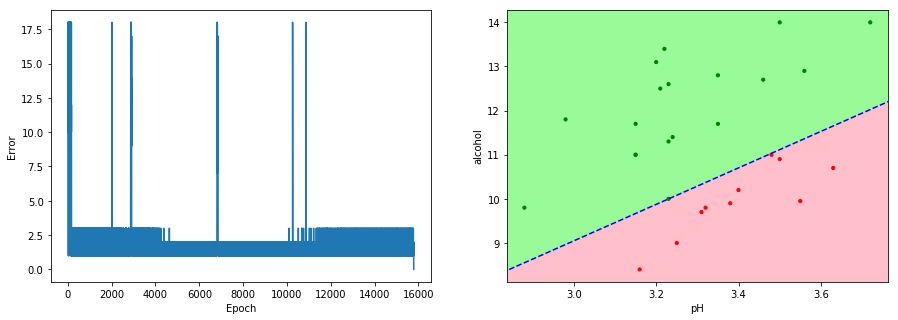

In [30]:
plot_performace(performance, data, target, 8, 3, -1, True)